## Setup


In [1]:
import numpy as np
import os
from typing import Sequence

from type_definitions.test_case import TestCase
from type_definitions.test_result import TestResult
from type_definitions.utils import *
from sklearn.mixture import GaussianMixture
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import OPTICS
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neighbors import BallTree
from torch.utils.data import Dataset, DataLoader
import pandas as pd

## Simulation


In [2]:
seed = 100
save_plot = False
use_cached_distance_matrix = True


np.random.seed(seed)

cases = generate_cases(500)
results = evaluate_cases(cases)
trajectories = [r.trajectory for r in results if not r.simulation_failed]
valid_results = [r for r in results if not r.simulation_failed]
print(f"Generated {len(trajectories)} valid trajectories")
print(
    f"Crashed: {sum(1 for r in valid_results if r.crashed)}, Safe: {sum(1 for r in valid_results if not r.crashed)}"
)

Generated 179 valid trajectories
Crashed: 123, Safe: 56


In [ ]:
os.makedirs("cache", exist_ok=True)
distance_matrix_file = f"cache/distance_matrix_seed{seed}_size{len(trajectories)}.npy"

if use_cached_distance_matrix and os.path.exists(distance_matrix_file):
    print(f"Loading altitude-based distance matrix from {distance_matrix_file}")
    distance_matrix = np.load(distance_matrix_file)
else:
    print("Calculating pairwise altitude distances...")
    distance_matrix = pairwise_distances(trajectories)
    np.save(distance_matrix_file, distance_matrix)
    print(f"Distance matrix saved to {distance_matrix_file}")

print(f"Distance matrix shape: {distance_matrix.shape}")

Calculating pairwise altitude distances...


## OPTIC Clustering


In [ ]:
# OPTICS clustering based on altitude trajectories
optics = OPTICS(min_samples=3, metric="precomputed", cluster_method="xi", xi=0.05)
clusters = optics.fit_predict(distance_matrix)
unique_clusters = np.unique(clusters)
reachability = optics.reachability_
ordering = optics.ordering_

# Calculate cluster statistics
print("Cluster statistics:")
for cluster_id in unique_clusters:
    if cluster_id == -1:  # Skip noise points
        continue
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = len(cluster_results)
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    print(
        f"    Cluster {cluster_id}: {crashed_in_cluster}/{total_in_cluster} crashed ({crash_rate:.2f}%)"
    )

Cluster statistics:
    Cluster 0: 0/5 crashed (0.00%)
    Cluster 1: 3/4 crashed (75.00%)
    Cluster 2: 2/3 crashed (66.67%)
    Cluster 3: 5/5 crashed (100.00%)
    Cluster 4: 5/5 crashed (100.00%)
    Cluster 5: 5/5 crashed (100.00%)
    Cluster 6: 7/8 crashed (87.50%)
    Cluster 7: 3/3 crashed (100.00%)
    Cluster 8: 6/6 crashed (100.00%)
    Cluster 9: 0/3 crashed (0.00%)


In [ ]:
# Calculate coverage metrics
total_test_cases = len(valid_results)
noise_points = np.sum(clusters == -1)
cluster_ids = unique_clusters[unique_clusters != -1]  # Exclude noise
num_clusters = len(cluster_ids)

# Calculate cluster sizes and proportions
cluster_sizes = {}
cluster_proportions = {}
cluster_coverage_percentages = {}

for cluster_id in cluster_ids:
    cluster_mask = clusters == cluster_id
    size = np.sum(cluster_mask)
    cluster_sizes[cluster_id] = size
    cluster_proportions[cluster_id] = (
        size / total_test_cases if total_test_cases > 0 else 0
    )
    cluster_coverage_percentages[cluster_id] = cluster_proportions[cluster_id] * 100

# Store coverage metrics
coverage_metrics = {
    "total_test_cases": total_test_cases,
    "num_clusters": num_clusters,
    "noise_points": noise_points,
    "noise_percentage": (
        (noise_points / total_test_cases * 100) if total_test_cases > 0 else 0
    ),
    "cluster_sizes": cluster_sizes,
    "cluster_proportions": cluster_proportions,
    "cluster_coverage_percentages": cluster_coverage_percentages,
}

In [ ]:
# Print coverage metrics summary
print("=" * 60)
print("OPTICS ALTITUDE-BASED CLUSTERING COVERAGE METRICS SUMMARY")
print("=" * 60)
print(f"\nTotal Test Cases: {coverage_metrics['total_test_cases']}")
print(f"Number of Clusters: {coverage_metrics['num_clusters']}")
print(
    f"Noise Points: {coverage_metrics['noise_points']} ({coverage_metrics['noise_percentage']:.2f}%)"
)
print(f"\nCluster Distribution:")
print("-" * 60)

# Sort clusters by size (descending)
sorted_clusters = sorted(cluster_ids, key=lambda x: cluster_sizes[x], reverse=True)

for cluster_id in sorted_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = cluster_sizes[cluster_id]
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    coverage_pct = cluster_coverage_percentages[cluster_id]

    print(
        f"Cluster {cluster_id:2d}: Size={total_in_cluster:3d} ({coverage_pct:5.2f}% coverage) | "
        f"Crashed={crashed_in_cluster:3d}/{total_in_cluster:3d} ({crash_rate:5.2f}%)"
    )

print("-" * 60)

# Calculate cluster size statistics
if len(cluster_sizes) > 0:
    sizes_list = list(cluster_sizes.values())
    print(f"\nCluster Size Statistics:")
    print(f"  Min: {min(sizes_list)}")
    print(f"  Max: {max(sizes_list)}")
    print(f"  Mean: {np.mean(sizes_list):.2f}")
    print(f"  Median: {np.median(sizes_list):.2f}")
    print(f"  Std Dev: {np.std(sizes_list):.2f}")

# Coverage distribution analysis
coverage_values = list(cluster_coverage_percentages.values())
if len(coverage_values) > 0:
    print(f"\nCoverage Distribution:")
    print(f"  Min Coverage: {min(coverage_values):.2f}%")
    print(f"  Max Coverage: {max(coverage_values):.2f}%")
    print(f"  Mean Coverage: {np.mean(coverage_values):.2f}%")
    print(
        f"  Coverage Balance Score: {1 - np.std(coverage_values) / np.mean(coverage_values):.3f} "
        + f"(1.0 = perfectly balanced, lower = more skewed)"
    )

print("=" * 60)
print("=" * 60)
print(f"\nTotal Test Cases: {coverage_metrics['total_test_cases']}")
print(f"Number of Clusters: {coverage_metrics['num_clusters']}")
print(
    f"Noise Points: {coverage_metrics['noise_points']} ({coverage_metrics['noise_percentage']:.2f}%)"
)
print(f"\nCluster Distribution:")
print("-" * 60)

# Sort clusters by size (descending)
sorted_clusters = sorted(cluster_ids, key=lambda x: cluster_sizes[x], reverse=True)

for cluster_id in sorted_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = cluster_sizes[cluster_id]
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    coverage_pct = cluster_coverage_percentages[cluster_id]

    print(
        f"Cluster {cluster_id:2d}: Size={total_in_cluster:3d} ({coverage_pct:5.2f}% coverage) | "
        f"Crashed={crashed_in_cluster:3d}/{total_in_cluster:3d} ({crash_rate:5.2f}%)"
    )

print("-" * 60)

# Calculate cluster size statistics
if len(cluster_sizes) > 0:
    sizes_list = list(cluster_sizes.values())
    print(f"\nCluster Size Statistics:")
    print(f"  Min: {min(sizes_list)}")
    print(f"  Max: {max(sizes_list)}")
    print(f"  Mean: {np.mean(sizes_list):.2f}")
    print(f"  Median: {np.median(sizes_list):.2f}")
    print(f"  Std Dev: {np.std(sizes_list):.2f}")

# Coverage distribution analysis
coverage_values = list(cluster_coverage_percentages.values())
if len(coverage_values) > 0:
    print(f"\nCoverage Distribution:")
    print(f"  Min Coverage: {min(coverage_values):.2f}%")
    print(f"  Max Coverage: {max(coverage_values):.2f}%")
    print(f"  Mean Coverage: {np.mean(coverage_values):.2f}%")
    print(
        f"  Coverage Balance Score: {1 - np.std(coverage_values) / np.mean(coverage_values):.3f} "
        + f"(1.0 = perfectly balanced, lower = more skewed)"
    )

print("=" * 60)
print(f"\nTotal Test Cases: {coverage_metrics['total_test_cases']}")
print(f"Number of Clusters: {coverage_metrics['num_clusters']}")
print(
    f"Noise Points: {coverage_metrics['noise_points']} ({coverage_metrics['noise_percentage']:.2f}%)"
)
print(f"\nCluster Distribution:")
print("-" * 60)

# Sort clusters by size (descending)
sorted_clusters = sorted(cluster_ids, key=lambda x: cluster_sizes[x], reverse=True)

for cluster_id in sorted_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = cluster_sizes[cluster_id]
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    coverage_pct = cluster_coverage_percentages[cluster_id]

    print(
        f"Cluster {cluster_id:2d}: Size={total_in_cluster:3d} ({coverage_pct:5.2f}% coverage) | "
        f"Crashed={crashed_in_cluster:3d}/{total_in_cluster:3d} ({crash_rate:5.2f}%)"
    )

print("-" * 60)

# Calculate cluster size statistics
if len(cluster_sizes) > 0:
    sizes_list = list(cluster_sizes.values())
    print(f"\nCluster Size Statistics:")
    print(f"  Min: {min(sizes_list)}")
    print(f"  Max: {max(sizes_list)}")
    print(f"  Mean: {np.mean(sizes_list):.2f}")
    print(f"  Median: {np.median(sizes_list):.2f}")
    print(f"  Std Dev: {np.std(sizes_list):.2f}")

# Coverage distribution analysis
coverage_values = list(cluster_coverage_percentages.values())
if len(coverage_values) > 0:
    print(f"\nCoverage Distribution:")
    print(f"  Min Coverage: {min(coverage_values):.2f}%")
    print(f"  Max Coverage: {max(coverage_values):.2f}%")
    print(f"  Mean Coverage: {np.mean(coverage_values):.2f}%")
    print(
        f"  Coverage Balance Score: {1 - np.std(coverage_values) / np.mean(coverage_values):.3f} "
        + f"(1.0 = perfectly balanced, lower = more skewed)"
    )

print("=" * 60)

OPTICS ALTITUDE-BASED CLUSTERING COVERAGE METRICS SUMMARY

Total Test Cases: 90
Number of Clusters: 10
Noise Points: 43 (47.78%)

Cluster Distribution:
------------------------------------------------------------
Cluster  6: Size=  8 ( 8.89% coverage) | Crashed=  7/  8 (87.50%)
Cluster  8: Size=  6 ( 6.67% coverage) | Crashed=  6/  6 (100.00%)
Cluster  0: Size=  5 ( 5.56% coverage) | Crashed=  0/  5 ( 0.00%)
Cluster  3: Size=  5 ( 5.56% coverage) | Crashed=  5/  5 (100.00%)
Cluster  4: Size=  5 ( 5.56% coverage) | Crashed=  5/  5 (100.00%)
Cluster  5: Size=  5 ( 5.56% coverage) | Crashed=  5/  5 (100.00%)
Cluster  1: Size=  4 ( 4.44% coverage) | Crashed=  3/  4 (75.00%)
Cluster  2: Size=  3 ( 3.33% coverage) | Crashed=  2/  3 (66.67%)
Cluster  7: Size=  3 ( 3.33% coverage) | Crashed=  3/  3 (100.00%)
Cluster  9: Size=  3 ( 3.33% coverage) | Crashed=  0/  3 ( 0.00%)
------------------------------------------------------------

Cluster Size Statistics:
  Min: 3
  Max: 8
  Mean: 4.70
  Me

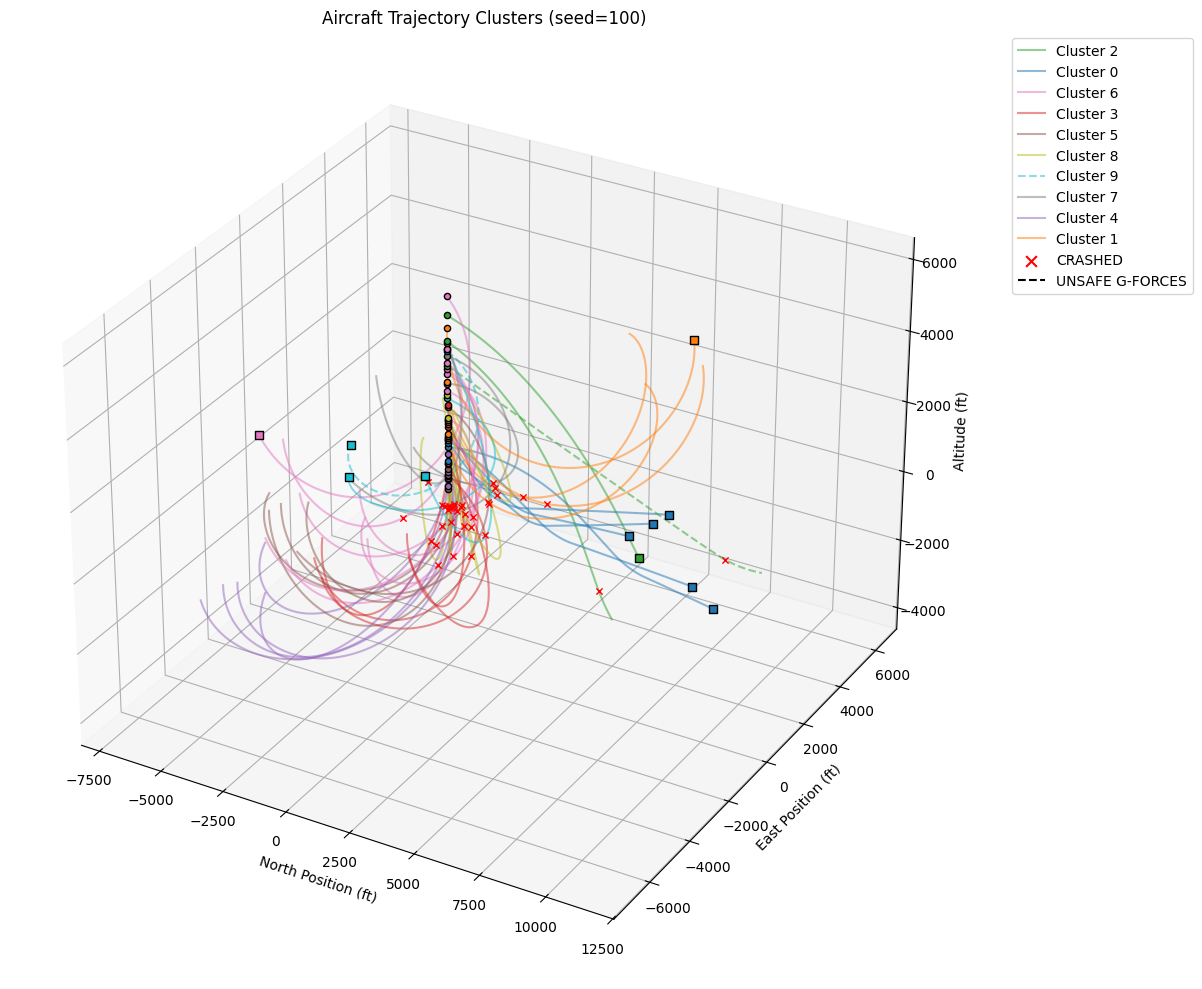

In [ ]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

valid_results = [r for r in results if not r.simulation_failed]

plotted_clusters = set()

for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # Skip noise points
        continue

    color = colors[cluster_id % len(colors)]
    if cluster_id not in plotted_clusters:
        label = f"Cluster {cluster_id}"
        plotted_clusters.add(cluster_id)
    else:
        label = None

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    ax.plot(
        traj[:, 0],
        traj[:, 1],
        traj[:, 2],
        color=color,
        alpha=0.5,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # start point
    ax.scatter(
        traj[0, 0],
        traj[0, 1],
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    # end points
    if result.crashed:
        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]
            crash_z = traj[min_alt_idx, 2]

        ax.scatter(
            crash_x,
            crash_y,
            crash_z,
            color="red",
            s=20,
            marker="x",
            linewidth=1,
        )
    else:
        ax.scatter(
            traj[-1, 0],
            traj[-1, 1],
            traj[-1, 2],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")

# Add legend for unsafe g-forces
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("North Position (ft)")
ax.set_ylabel("East Position (ft)")
ax.set_zlabel("Altitude (ft)")
ax.set_title(f"Aircraft Trajectory Clusters (seed={seed})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_3d.png")
    print(f"Plot saved to results/{seed}_clusters_3d.png")

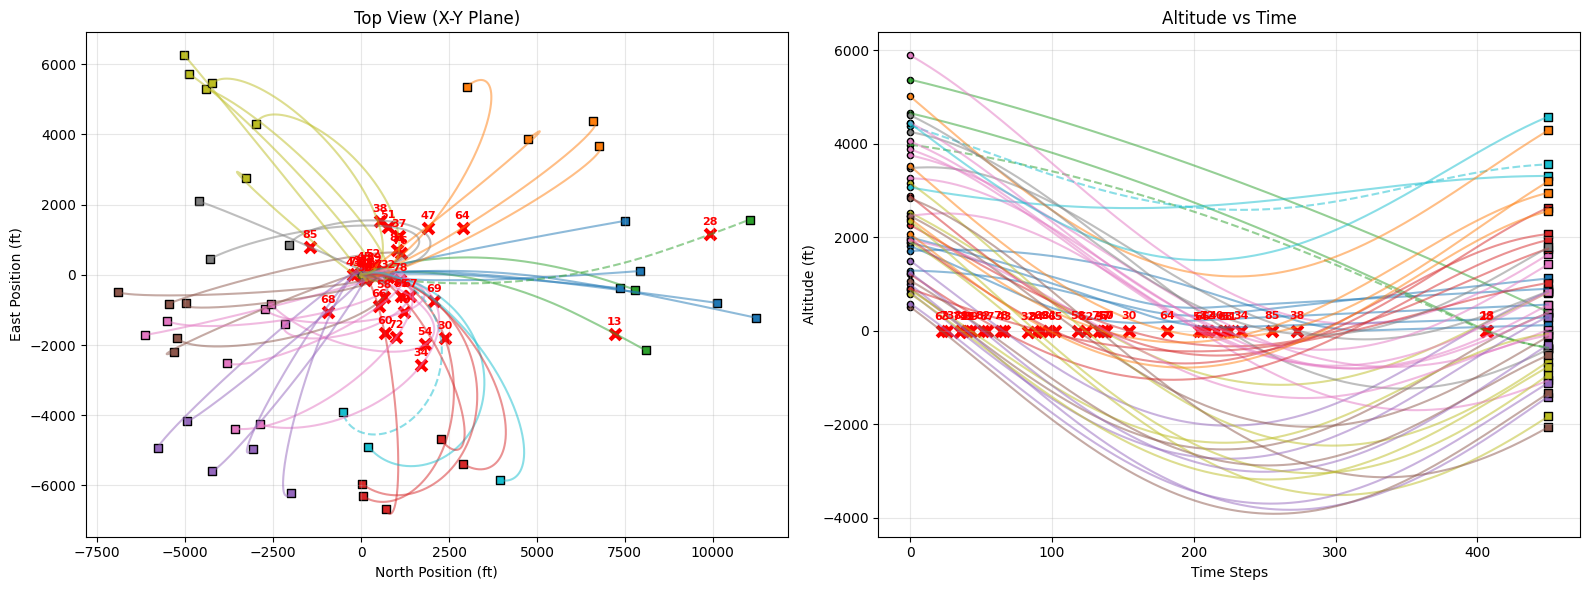

In [ ]:
# 2D plotting - x-y plane and altitude vs time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# x-y plane
ax1 = axes[0]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # Skip noise points
        continue

    color = colors[cluster_id % len(colors)]

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    if result.crashed:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]

        ax1.scatter(
            crash_x,
            crash_y,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax1.text(
            crash_x,
            crash_y + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

    ax1.scatter(
        traj[0, 0],
        traj[0, 1],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax1.scatter(
        traj[-1, 0],
        traj[-1, 1],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax1.set_xlabel("North Position (ft)")
ax1.set_ylabel("East Position (ft)")
ax1.set_title("Top View (X-Y Plane)")
ax1.grid(True, alpha=0.3)

# altitude vs time
ax2 = axes[1]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # Skip noise points
        continue

    color = colors[cluster_id % len(colors)]

    time_steps = np.arange(len(traj))

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    if result.crashed:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_time = time_steps[crash_idx]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_time = time_steps[min_alt_idx]
            crash_z = traj[min_alt_idx, 2]

        ax2.scatter(
            crash_time,
            crash_z,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax2.text(
            crash_time,
            crash_z + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

    ax2.scatter(
        0,
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax2.scatter(
        len(traj) - 1,
        traj[-1, 2],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Altitude (ft)")
ax2.set_title("Altitude vs Time")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_2d.png")
    print(f"2D plots saved to results/{seed}_clusters_2d.png")

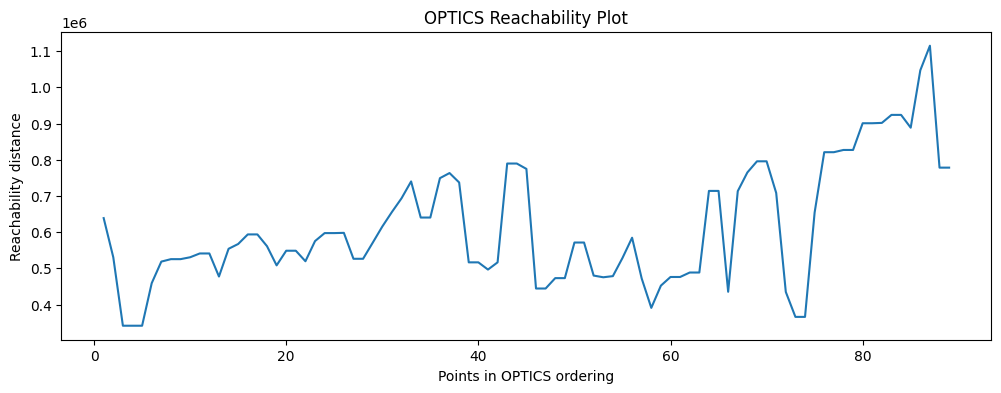

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(reachability[ordering])
plt.xlabel("Points in OPTICS ordering")
plt.ylabel("Reachability distance")
plt.title("OPTICS Reachability Plot")
plt.show()

## Gaussian Mixture Model (GMM) Clustering


In [7]:
# Apply MDS to convert altitude-based distance matrix to feature space
print("Applying MDS transformation...")
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=seed)
X_transformed = mds.fit_transform(distance_matrix)
print(f"MDS transformed features shape: {X_transformed.shape}")
print(f"MDS stress: {mds.stress_:.4f}")

Applying MDS transformation...
MDS transformed features shape: (52, 2)
MDS stress: 205870506.5103


/Users/y65ng/Developer/unc/research/code/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [8]:
# Apply GMM clustering with n=5 components based on altitude trajectories
n_components = 5
print(f"Applying GMM clustering with {n_components} components...")
gmm = GaussianMixture(n_components=n_components, random_state=seed)
gmm.fit(X_transformed)

# Apply clustering
clusters = gmm.predict(X_transformed)
cluster_probs = gmm.predict_proba(X_transformed)
unique_clusters = np.unique(clusters)

Applying GMM clustering with 5 components...


In [9]:
# Calculate cluster statistics
for cluster_id in unique_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = len(cluster_results)
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    print(
        f"Cluster {cluster_id}: {crashed_in_cluster}/{total_in_cluster} crashed ({crash_rate:.2f}%)"
    )

Cluster 0: 7/7 crashed (100.00%)
Cluster 1: 10/17 crashed (58.82%)
Cluster 2: 0/7 crashed (0.00%)
Cluster 3: 10/11 crashed (90.91%)
Cluster 4: 10/10 crashed (100.00%)


In [10]:
# Second-stage clustering on mixed (neither all-crashed nor all-safe) clusters
# Identify mixed clusters from the first-stage GMM
mixed_cluster_ids = []
for cluster_id in unique_clusters:
    mask = clusters == cluster_id
    total = int(np.sum(mask))
    if total == 0:
        continue
    crashed = sum(
        1 for i in range(len(valid_results)) if mask[i] and valid_results[i].crashed
    )
    if 0 < crashed < total:
        mixed_cluster_ids.append(int(cluster_id))

print(f"Mixed clusters selected for separate re-clustering: {mixed_cluster_ids}")

# Perform second-stage clustering separately within each mixed cluster
second_stage_results = []  # list of dicts: {parent_id, X, clusters, valid_results}
for parent_id in mixed_cluster_ids:
    parent_mask = clusters == parent_id
    X_parent = X_transformed[parent_mask]
    valid_results_parent = [res for res, m in zip(valid_results, parent_mask) if m]

    print(f"Parent cluster {parent_id}: {len(valid_results_parent)} samples")

    if len(valid_results_parent) >= 2:
        n_components_parent = 5 if len(valid_results_parent) >= 2 else 1
        print(
            f"  Re-clustering parent {parent_id} with {n_components_parent} components..."
        )
        gmm_parent = GaussianMixture(
            n_components=n_components_parent, random_state=seed
        )
        gmm_parent.fit(X_parent)
        clusters_parent = gmm_parent.predict(X_parent)

        # Report stats per second-stage subcluster
        for sub_id in np.unique(clusters_parent):
            sub_mask = clusters_parent == sub_id
            sub_results = [
                valid_results_parent[i]
                for i in range(len(valid_results_parent))
                if sub_mask[i]
            ]
            crashed_in_sub = sum(1 for r in sub_results if r.crashed)
            total_in_sub = len(sub_results)
            crash_rate_sub = (
                (crashed_in_sub / total_in_sub) * 100 if total_in_sub > 0 else 0
            )
            print(
                f"  Parent {parent_id} -> Sub {sub_id}: {crashed_in_sub}/{total_in_sub} crashed ({crash_rate_sub:.2f}%)"
            )

        second_stage_results.append(
            {
                "parent_id": int(parent_id),
                "X": X_parent,
                "clusters": clusters_parent,
                "valid_results": valid_results_parent,
            }
        )
    else:
        print(
            f"  Not enough samples in parent {parent_id} for re-clustering; skipping."
        )

Mixed clusters selected for separate re-clustering: [1, 3]
Parent cluster 1: 17 samples
  Re-clustering parent 1 with 5 components...
  Parent 1 -> Sub 0: 2/5 crashed (40.00%)
  Parent 1 -> Sub 1: 3/4 crashed (75.00%)
  Parent 1 -> Sub 2: 1/3 crashed (33.33%)
  Parent 1 -> Sub 3: 4/4 crashed (100.00%)
  Parent 1 -> Sub 4: 0/1 crashed (0.00%)
Parent cluster 3: 11 samples
  Re-clustering parent 3 with 5 components...
  Parent 3 -> Sub 0: 5/5 crashed (100.00%)
  Parent 3 -> Sub 1: 1/1 crashed (100.00%)
  Parent 3 -> Sub 2: 0/1 crashed (0.00%)
  Parent 3 -> Sub 3: 3/3 crashed (100.00%)
  Parent 3 -> Sub 4: 1/1 crashed (100.00%)


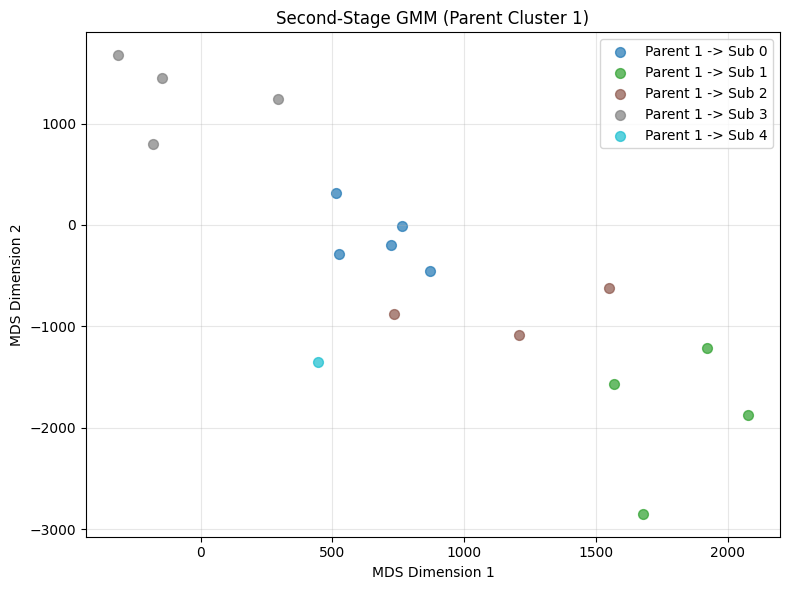

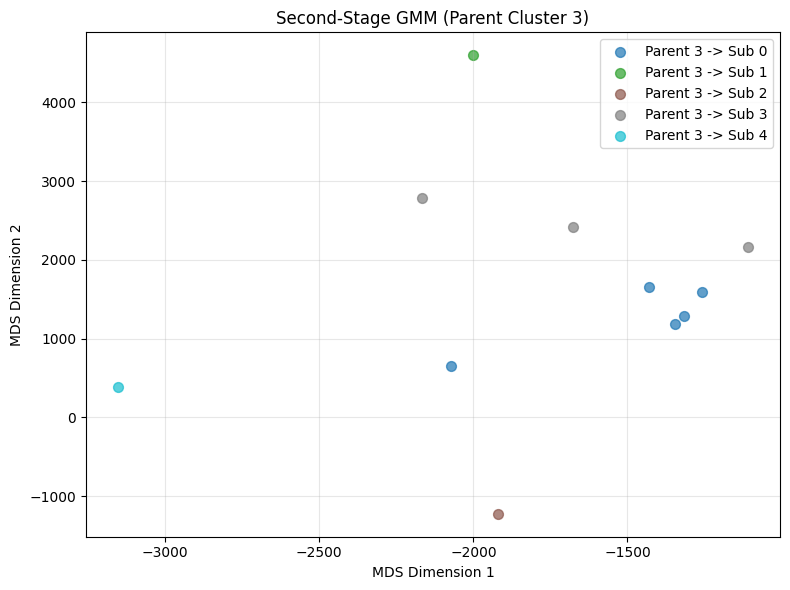

In [11]:
# Visualize second-stage clusters per parent (MDS space)
if "second_stage_results" in globals() and len(second_stage_results) > 0:
    for res in second_stage_results:
        parent_id = res["parent_id"]
        Xp = res["X"]
        cp = res["clusters"]
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(np.unique(cp))))
        for sub_id in np.unique(cp):
            mask = cp == sub_id
            ax.scatter(
                Xp[mask, 0],
                Xp[mask, 1],
                c=[colors[sub_id % len(colors)]],
                label=f"Parent {parent_id} -> Sub {sub_id}",
                alpha=0.7,
                s=50,
            )
        ax.set_xlabel("MDS Dimension 1")
        ax.set_ylabel("MDS Dimension 2")
        ax.set_title(f"Second-Stage GMM (Parent Cluster {parent_id})")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("Second-stage clustering results not available.")

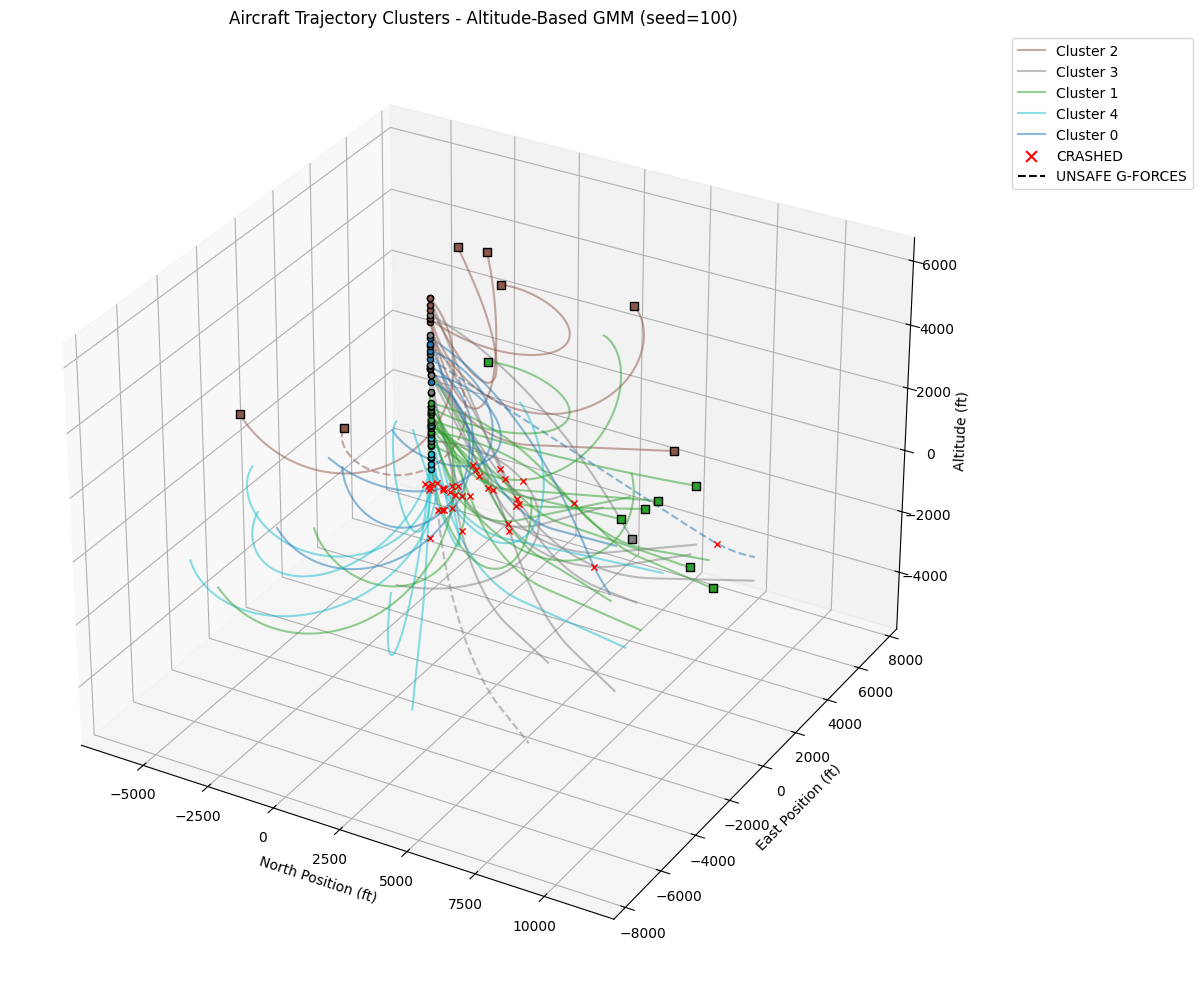

In [12]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

plotted_clusters = set()

for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    color = colors[cluster_id % len(colors)]
    if cluster_id not in plotted_clusters:
        label = f"Cluster {cluster_id}"
        plotted_clusters.add(cluster_id)
    else:
        label = None

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    ax.plot(
        traj[:, 0],
        traj[:, 1],
        traj[:, 2],
        color=color,
        alpha=0.5,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # start point
    ax.scatter(
        traj[0, 0],
        traj[0, 1],
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    # end points
    if result.crashed:
        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]
            crash_z = traj[min_alt_idx, 2]

        ax.scatter(
            crash_x,
            crash_y,
            crash_z,
            color="red",
            s=20,
            marker="x",
            linewidth=1,
        )
    else:
        # Safe landing point
        ax.scatter(
            traj[-1, 0],
            traj[-1, 1],
            traj[-1, 2],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

# Add legend for crashed trajectories
if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")

# Add legend for unsafe g-forces
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("North Position (ft)")
ax.set_ylabel("East Position (ft)")
ax.set_zlabel("Altitude (ft)")
ax.set_title(f"Aircraft Trajectory Clusters - Altitude-Based GMM (seed={seed})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
if save_plot:
    plt.savefig(
        f"results/gmm_{n_components}_clusters_3d.png", dpi=300, bbox_inches="tight"
    )
    print(f"Plot saved to results/gmm_{n_components}_clusters_3d.png")

plt.show()

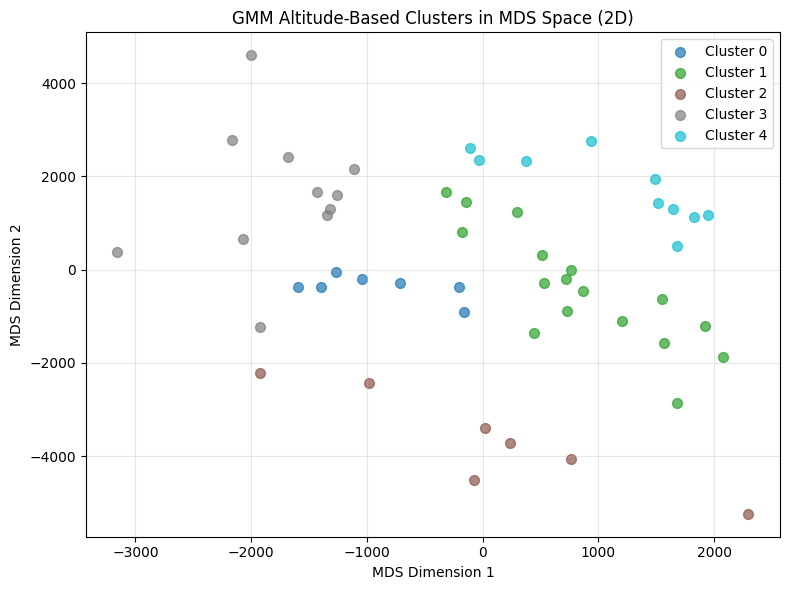

In [13]:
# Visualize clusters in MDS space
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

for cluster_id in unique_clusters:
    mask = clusters == cluster_id
    color = colors[cluster_id % len(colors)]

    # Plot first two MDS dimensions
    ax1.scatter(
        X_transformed[mask, 0],
        X_transformed[mask, 1],
        c=[color],
        label=f"Cluster {cluster_id}",
        alpha=0.7,
        s=50,
    )

ax1.set_xlabel("MDS Dimension 1")
ax1.set_ylabel("MDS Dimension 2")
ax1.set_title("GMM Altitude-Based Clusters in MDS Space (2D)")
ax1.legend()
ax1.grid(True, alpha=0.3)


plt.tight_layout()

if save_plot:
    plt.savefig(
        f"results/gmm_{n_components}_clusters_mds.png",
        dpi=300,
        bbox_inches="tight",
    )
    print(f"MDS plot saved to results/gmm_{n_components}_clusters_mds.png")

plt.show()

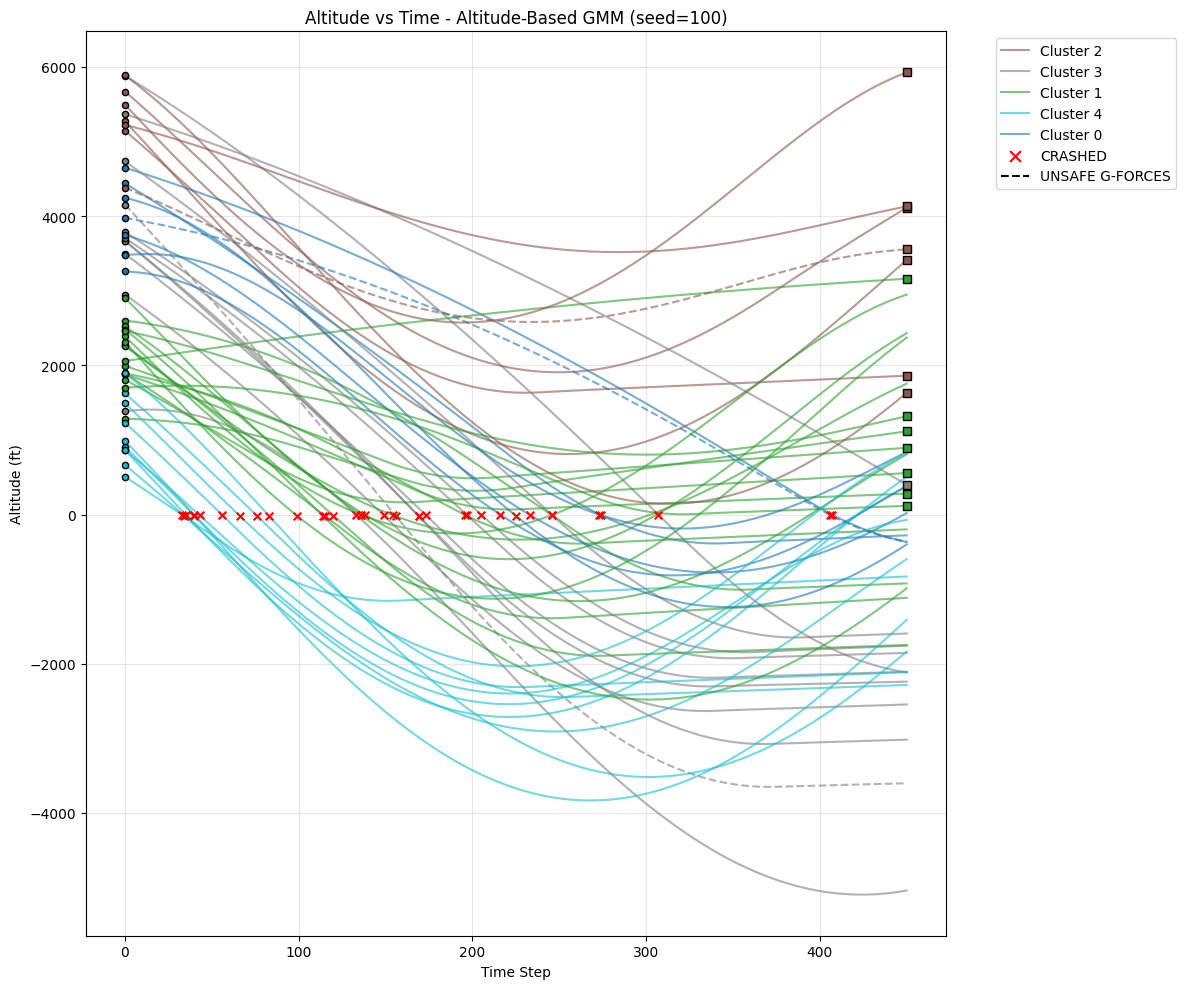

In [14]:
# Altitude vs Time Visualization
fig, ax = plt.subplots(figsize=(12, 10))

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))
plotted_clusters = set()

for traj, cluster_id, result in zip(trajectories, clusters, valid_results):
    color = colors[cluster_id % len(colors)]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    plotted_clusters.add(cluster_id)

    # Style for unsafe g-forces
    line_style = "--" if has_unsafe_gforces(traj) else "-"

    # Time index and altitude
    t = np.arange(traj.shape[0])
    alt = traj[:, 2]

    # Plot altitude vs time
    ax.plot(
        t,
        alt,
        color=color,
        alpha=0.6,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # Start point
    ax.scatter(
        0,
        alt[0],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
        zorder=3,
    )

    # End point (crash or safe)
    if result.crashed:
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]
            crash_t = crash_idx
            crash_alt = alt[crash_idx]
        else:
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_t = min_alt_idx
            crash_alt = alt[min_alt_idx]
        ax.scatter(
            crash_t, crash_alt, color="red", s=30, marker="x", linewidth=1.5, zorder=4
        )
    else:
        ax.scatter(
            t[-1],
            alt[-1],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
            zorder=4,
        )

# Legend handles
if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("Time Step")
ax.set_ylabel("Altitude (ft)")
ax.set_title(f"Altitude vs Time - Altitude-Based GMM (seed={seed})")
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()

if save_plot:
    os.makedirs("results", exist_ok=True)
    plt.savefig(
        f"results/gmm_{n_components}_clusters_altitude_time.png",
        dpi=300,
        bbox_inches="tight",
    )
    print(f"Plot saved to results/gmm_{n_components}_clusters_altitude_time.png")

plt.show()

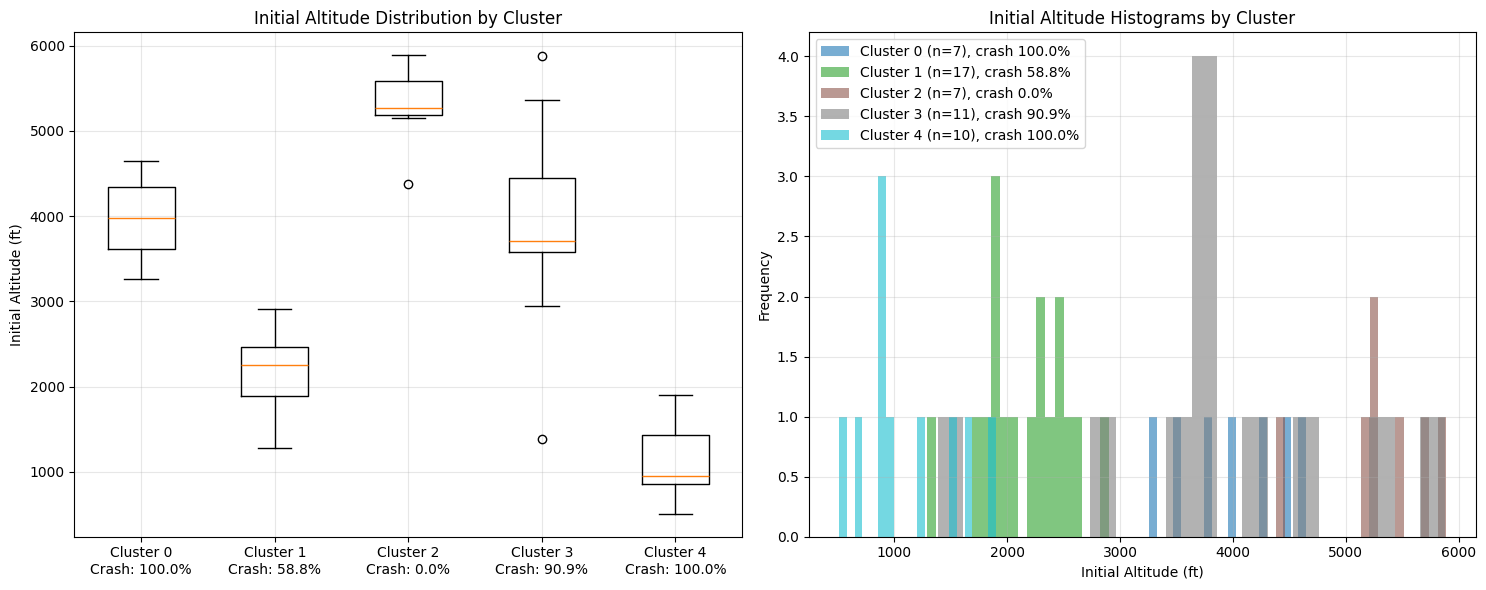

In [15]:
# Visualize altitude distributions by cluster
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot of altitude by cluster
cluster_alts = []
cluster_labels = []
for cluster_id in unique_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    cluster_altitudes = [r.test_case.alt for r in cluster_results]
    crashed_count = sum(1 for r in cluster_results if r.crashed)
    total_count = len(cluster_results)
    crash_rate = (crashed_count / total_count) * 100 if total_count > 0 else 0.0
    cluster_alts.append(cluster_altitudes)
    cluster_labels.append(f"Cluster {cluster_id}\nCrash: {crash_rate:.1f}%")

ax1.boxplot(cluster_alts, tick_labels=cluster_labels)
ax1.set_ylabel("Initial Altitude (ft)")
ax1.set_title("Initial Altitude Distribution by Cluster")
ax1.grid(True, alpha=0.3)

# Histogram of altitude distributions
colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))
for i, cluster_id in enumerate(unique_clusters):
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    cluster_altitudes = [r.test_case.alt for r in cluster_results]
    crashed_count = sum(1 for r in cluster_results if r.crashed)
    total_count = len(cluster_results)
    crash_rate = (crashed_count / total_count) * 100 if total_count > 0 else 0.0

    ax2.hist(
        cluster_altitudes,
        bins=20,
        alpha=0.6,
        label=f"Cluster {cluster_id} (n={len(cluster_altitudes)}), crash {crash_rate:.1f}%",
        color=colors[i % len(colors)],
    )

ax2.set_xlabel("Initial Altitude (ft)")
ax2.set_ylabel("Frequency")
ax2.set_title("Initial Altitude Histograms by Cluster")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Variable -> Crash relationship summary
--------------------------------------------------
Altitude (ft)    | corr=-0.299 | safe mean=3708.44 | crash mean=2696.73
Velocity (ft/s)  | corr=-0.042 | safe mean=677.85 | crash mean=668.68
Alpha (deg)      | corr=+0.068 | safe mean=4.79 | crash mean=5.23
Beta (deg)       | corr=+0.045 | safe mean=-3.44 | crash mean=-2.33
Phi (deg)        | corr=+0.046 | safe mean=-16.85 | crash mean=-5.50
Theta (deg)      | corr=-0.293 | safe mean=-34.46 | crash mean=-52.09
Power            | corr=+0.000 | safe mean=9.00 | crash mean=9.00


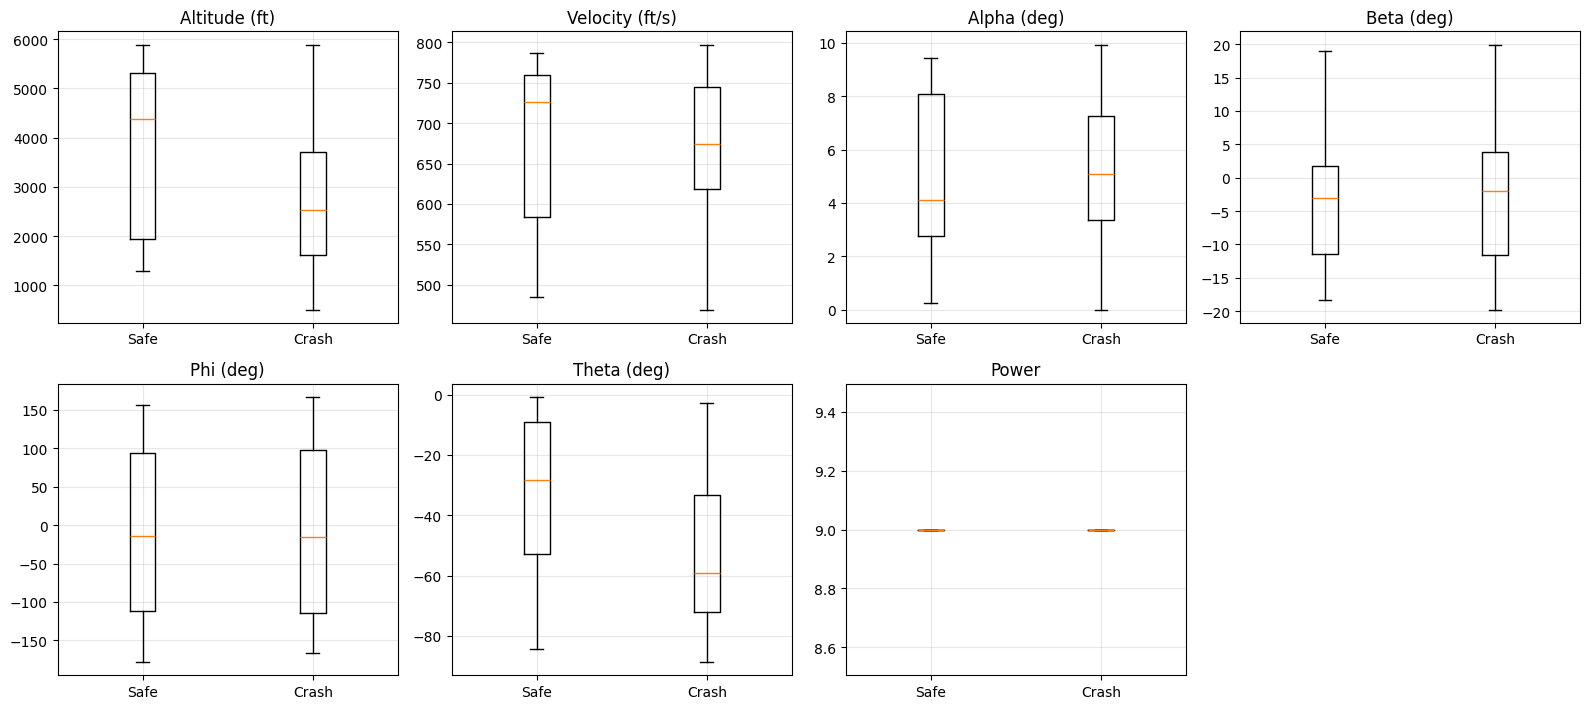

In [16]:
# Relationship of initial variables to crash outcome
from sklearn.metrics import roc_auc_score

# Collect initial variables and crash labels
labels = np.array([1 if r.crashed else 0 for r in valid_results])
vars_dict = {
    "Altitude (ft)": np.array([r.test_case.alt for r in valid_results]),
    "Velocity (ft/s)": np.array([r.test_case.vt for r in valid_results]),
    "Alpha (deg)": np.rad2deg(np.array([r.test_case.alpha for r in valid_results])),
    "Beta (deg)": np.rad2deg(np.array([r.test_case.beta for r in valid_results])),
    "Phi (deg)": np.rad2deg(np.array([r.test_case.phi for r in valid_results])),
    "Theta (deg)": np.rad2deg(np.array([r.test_case.theta for r in valid_results])),
    "Power": np.array([r.test_case.power for r in valid_results]),
}

print("Variable -> Crash relationship summary")
print("-" * 50)
for name, values in vars_dict.items():
    # Pearson correlation with binary label (point-biserial equivalent)
    corr = float(np.corrcoef(values, labels)[0, 1]) if np.std(values) > 0 else 0.0
    safe_vals = values[labels == 0]
    crash_vals = values[labels == 1]
    print(
        f"{name:16s} | corr={corr:+.3f} | safe mean={np.mean(safe_vals):.2f} | crash mean={np.mean(crash_vals):.2f}"
    )

# Boxplots comparing crashed vs safe for each variable
num_vars = len(vars_dict)
cols = 4
rows = int(np.ceil(num_vars / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.6 * rows))
axes = axes.flatten()

for ax, (name, values) in zip(axes, vars_dict.items()):
    data = [values[labels == 0], values[labels == 1]]
    ax.boxplot(data, tick_labels=["Safe", "Crash"])
    ax.set_title(name)
    ax.grid(True, alpha=0.3)

# Hide any unused subplots
for j in range(len(vars_dict), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Util Functions for Training


In [ ]:
def testcase_to_ndarray(test_case: TestCase) -> np.ndarray:

    return np.array(
        [
            test_case.vt,
            test_case.alpha,
            test_case.beta,
            test_case.phi,
            test_case.theta,
            test_case.psi,
            test_case.alt,
            test_case.power,
        ]
    )


test_cases = [r.test_case for r in valid_results]
features = np.array([testcase_to_ndarray(case) for case in test_cases])
features.shape


def pair_features_between(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    feat_diff = a - b
    feat_abs_diff = np.abs(feat_diff)
    euclidean_dist = np.linalg.norm(feat_diff)
    angular_indices = [1, 2, 3, 4, 5]
    angular_diffs = []
    for idx in angular_indices:
        d = feat_diff[idx]
        while d > np.pi:
            d -= 2 * np.pi
        while d < -np.pi:
            d += 2 * np.pi
        angular_diffs.append(d)
    return np.concatenate([feat_diff, feat_abs_diff, [euclidean_dist], angular_diffs])


def ndarray_to_testcase(arr: Sequence[float]) -> TestCase:
    return TestCase(
        vt=float(arr[0]),
        alpha=float(arr[1]),
        beta=float(arr[2]),
        phi=float(arr[3]),
        theta=float(arr[4]),
        psi=float(arr[5]),
        alt=float(arr[6]),
        power=float(arr[7]),
    )

In [ ]:
def create_pairwise_features(
    features: NDArray[np.float64], distance_matrix: NDArray[np.float64]
) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    n = features.shape[0]
    pairwise_features = []
    distances = []

    # Use upper triangular matrix to avoid duplicates
    for i in range(n):
        for j in range(i + 1, n):
            # Feature differences
            feat_diff = features[i] - features[j]
            feat_abs_diff = np.abs(feat_diff)

            # Additional features
            euclidean_dist = np.linalg.norm(feat_diff)

            # Angular differences for angles (alpha, beta, phi, theta, psi)
            angular_indices = [1, 2, 3, 4, 5]  # alpha, beta, phi, theta, psi
            angular_diffs = []
            for idx in angular_indices:
                diff = feat_diff[idx]
                # Normalize to [-pi, pi]
                while diff > np.pi:
                    diff -= 2 * np.pi
                while diff < -np.pi:
                    diff += 2 * np.pi
                angular_diffs.append(diff)

            # Combine all features
            combined_features = np.concatenate(
                [
                    feat_diff,
                    feat_abs_diff,
                    [euclidean_dist],
                    angular_diffs,
                ]
            )

            pairwise_features.append(combined_features)
            distances.append(distance_matrix[i, j])

    return np.array(pairwise_features), np.array(distances)


X, y = create_pairwise_features(features, distance_matrix)

print(f"Pairwise features shape: {X.shape}")
print(f"Distances shape: {y.shape}")

Pairwise features shape: (4005, 22)
Distances shape: (4005,)


## Random Forest Regression


In [12]:
# Helper methods


def sample_test_cases_with_rf(
    rf_model: RandomForestRegressor,
    scaler: StandardScaler,
    base_features: np.ndarray,
    n_select: int = 20,
    n_candidates: int = 2000,
    seed: int = 100,
    include_selected_in_pool: bool = True,
) -> list[TestCase]:
    rng = np.random.default_rng(seed)
    feat_min = base_features.min(axis=0)
    feat_max = base_features.max(axis=0)
    candidates = rng.uniform(
        low=feat_min, high=feat_max, size=(n_candidates, base_features.shape[1])
    )
    pool = base_features.copy()
    selected = []

    for _ in range(n_select):
        pool_sub = pool
        min_pred = np.full(n_candidates, np.inf, dtype=float)
        batch_size = 512
        for start in range(0, len(pool_sub), batch_size):
            end = min(start + batch_size, len(pool_sub))
            batch = pool_sub[start:end]

            pairs = []
            for b in batch:
                diffs = candidates - b
                abs_diffs = np.abs(diffs)
                eucl = np.linalg.norm(diffs, axis=1, keepdims=True)
                ang_idx = [1, 2, 3, 4, 5]
                ang_diffs = []
                for idx in ang_idx:
                    d = diffs[:, idx].copy()
                    d = (d + np.pi) % (2 * np.pi) - np.pi
                    ang_diffs.append(d.reshape(-1, 1))
                ang_diffs = np.hstack(ang_diffs)
                pair_block = np.hstack([diffs, abs_diffs, eucl, ang_diffs])
                pairs.append(pair_block)

            pairmat = np.vstack(pairs)
            pairmat_scaled = scaler.transform(pairmat)
            preds = rf_model.predict(pairmat_scaled).reshape(-1)
            preds_reshaped = preds.reshape(len(batch), n_candidates)
            batch_min = preds_reshaped.min(axis=0)
            min_pred = np.minimum(min_pred, batch_min)

        best_idx = int(np.argmax(min_pred))
        best = candidates[best_idx]
        selected.append(best)
        if include_selected_in_pool:
            pool = np.vstack([pool, best[None, :]])
        candidates[best_idx] = rng.uniform(
            low=feat_min, high=feat_max, size=(base_features.shape[1],)
        )

    return [ndarray_to_testcase(s) for s in selected]


def run_active_coverage_cycles(
    init_cases: list[TestCase],
    cycles: int = 5,
    per_cycle_new: int = 20,
    n_candidates: int = 2000,
    seed: int = 100,
    cache_distances: bool = True,
):
    rng = np.random.default_rng(seed)
    results_all = evaluate_cases(init_cases)
    trajectories = [r.trajectory for r in results_all if not r.simulation_failed]
    test_cases = [r.test_case for r in results_all if not r.simulation_failed]
    features = np.array([testcase_to_ndarray(tc) for tc in test_cases])

    for c in range(1, cycles + 1):
        distance_matrix_file = (
            f"cache/distance_matrix_seed{seed}_size{len(trajectories)}.npy"
        )
        if cache_distances and os.path.exists(distance_matrix_file):
            distance_matrix = np.load(distance_matrix_file)
        else:
            distance_matrix = pairwise_distances(trajectories, distance_type="dtw")
            if cache_distances:
                np.save(distance_matrix_file, distance_matrix)

        width, uniformity = frechet_coverage(distance_matrix)
        print(
            f"[Cycle {c}] N={len(trajectories)} width={width:.2f} uniformity={uniformity:.4f}"
        )

        X, y = create_pairwise_features(features, distance_matrix)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        rf_model = RandomForestRegressor(
            n_estimators=100, max_depth=20, random_state=seed, n_jobs=-1
        )
        rf_model.fit(X_train_scaled, y_train)

        new_cases = sample_test_cases_with_rf(
            rf_model=rf_model,
            scaler=scaler,
            base_features=features,
            n_select=per_cycle_new,
            n_candidates=n_candidates,
            seed=int(rng.integers(0, 1_000_000)),
            include_selected_in_pool=True,
        )

        new_results = evaluate_cases(new_cases)
        new_valid = [r for r in new_results if not r.simulation_failed]
        new_trajs = [r.trajectory for r in new_valid]
        new_feats = np.array([testcase_to_ndarray(r.test_case) for r in new_valid])

        if len(new_trajs) == 0:
            print(f"[Cycle {c}] No valid new trajectories; stopping.")
            break

        results_all.extend(new_valid)
        trajectories.extend(new_trajs)
        features = np.vstack([features, new_feats])

    distance_matrix = pairwise_distances(trajectories, distance_type="dtw")
    width, uniformity = frechet_coverage(distance_matrix)
    print(
        f"[Final] N={len(trajectories)} width={width:.2f} uniformity={uniformity:.4f}"
    )
    return results_all, trajectories, features

In [13]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 3204 samples
Test set: 801 samples


In [14]:
initial_cases = [r.test_case for r in valid_results]

# results_all, trajectories_all, features_all = run_active_coverage_cycles(
#     init_cases=initial_cases,
#     cycles=2,
#     per_cycle_new=20,
#     n_candidates=2000,
#     seed=seed,
#     cache_distances=True,
# )

In [15]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=20, random_state=seed, n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=100)

In [16]:
# Make predictions
rf_predictions = rf_model.predict(X_test_scaled)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = rf_model.score(X_test_scaled, y_test)


print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R squared: {rf_r2:.4f}")

MAE: 522565.41
RMSE: 675919.74
R squared: 0.4079


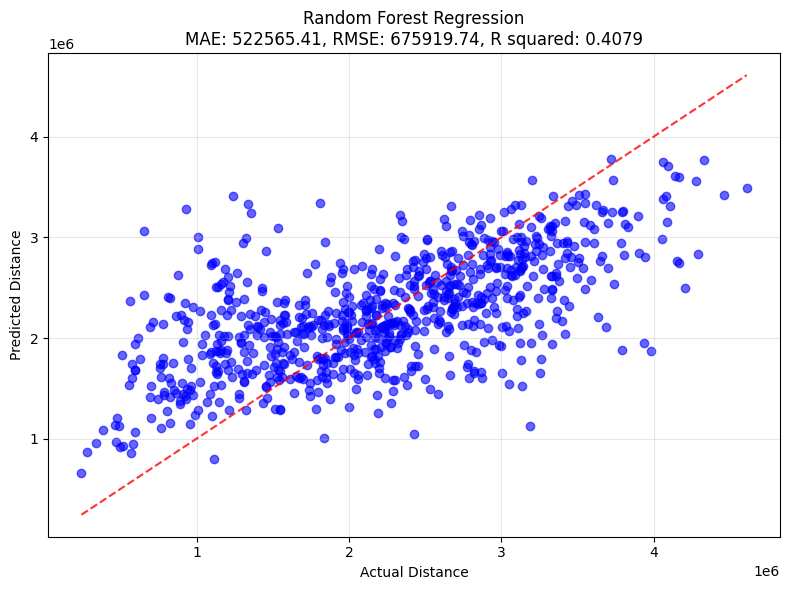

In [17]:
# Visualize results
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(y_test, rf_predictions, alpha=0.6, color="blue")
min_val = min(y_test.min(), rf_predictions.min())
max_val = max(y_test.max(), rf_predictions.max())
ax.plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
ax.set_xlabel("Actual Distance")
ax.set_ylabel("Predicted Distance")
ax.set_title(
    f"Random Forest Regression\nMAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R squared: {rf_r2:.4f}"
)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Feature importance analysis
feature_names = [
    "vt_diff",
    "alpha_diff",
    "beta_diff",
    "phi_diff",
    "theta_diff",
    "psi_diff",
    "alt_diff",
    "power_diff",
    "vt_abs_diff",
    "alpha_abs_diff",
    "beta_abs_diff",
    "phi_abs_diff",
    "theta_abs_diff",
    "psi_abs_diff",
    "alt_abs_diff",
    "power_abs_diff",
    "euclidean_dist",
    "alpha_angular_diff",
    "beta_angular_diff",
    "phi_angular_diff",
    "theta_angular_diff",
    "psi_angular_diff",
]

# Get feature importances
rf_importances = rf_model.feature_importances_

# Sort features by importance
rf_indices = np.argsort(rf_importances)[::-1]

print("Top 10 Most Important Features:")
for i in range(min(10, len(feature_names))):
    idx = rf_indices[i]
    print(f"  {i+1}. {feature_names[idx]}: {rf_importances[idx]:.4f}")

Top 10 Most Important Features:
  1. phi_abs_diff: 0.2958
  2. vt_abs_diff: 0.0749
  3. alt_abs_diff: 0.0682
  4. euclidean_dist: 0.0673
  5. vt_diff: 0.0616
  6. alt_diff: 0.0491
  7. theta_angular_diff: 0.0466
  8. theta_diff: 0.0464
  9. beta_abs_diff: 0.0385
  10. theta_abs_diff: 0.0381


## Gaussian Processes


In [135]:
# Prepare data for Gaussian Process Regression
# Create pairwise features from test cases and distance matrix

# Get test cases from valid results
test_cases_gp = [r.test_case for r in valid_results]
features_gp = np.array([testcase_to_ndarray(case) for case in test_cases_gp])

# Create pairwise features and distances
X_gp, y_gp = create_pairwise_features(features_gp, distance_matrix)

print(f"Pairwise features shape: {X_gp.shape}")
print(f"Distances shape: {y_gp.shape}")

# Split data into train/test sets
X_train_gp, X_test_gp, y_train_gp, y_test_gp = train_test_split(
    X_gp, y_gp, test_size=0.2, random_state=seed
)

print(f"Training set: {X_train_gp.shape[0]} samples")
print(f"Test set: {X_test_gp.shape[0]} samples")

# Normalize features
scaler_gp = StandardScaler()
X_train_gp_scaled = scaler_gp.fit_transform(X_train_gp)
X_test_gp_scaled = scaler_gp.transform(X_test_gp)

Pairwise features shape: (4005, 22)
Distances shape: (4005,)
Training set: 3204 samples
Test set: 801 samples


In [136]:
# Train Gaussian Process Regressor
# Note: GPs can be computationally expensive for large datasets
# Using a composite kernel: RBF + WhiteKernel for noise modeling

# Define kernel: RBF (Radial Basis Function) with automatic relevance determination
# + WhiteKernel for noise estimation
kernel = ConstantKernel(1.0, constant_value_bounds=(1e-3, 1e3)) * RBF(
    length_scale=1.0, length_scale_bounds=(1e-2, 1e2)
) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-3, 1e3))

# Create GP model
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-6,  # Small value for numerical stability
    n_restarts_optimizer=10,  # Number of restarts for hyperparameter optimization
    random_state=seed,
    normalize_y=True,  # Normalize target values for better performance
)

print("Training Gaussian Process Regressor...")
print(f"Training set size: {X_train_gp_scaled.shape[0]} samples")
print("This may take a few minutes...")

# Fit the model
gp_model.fit(X_train_gp_scaled, y_train_gp)

print("Training completed!")
print(f"Optimized kernel: {gp_model.kernel_}")

Training Gaussian Process Regressor...
Training set size: 3204 samples
This may take a few minutes...
Training completed!
Optimized kernel: 0.987**2 * RBF(length_scale=3.03) + WhiteKernel(noise_level=0.474)


In [137]:
# Make predictions with GP model
# GP provides both mean predictions and uncertainty estimates
gp_predictions, gp_std = gp_model.predict(X_test_gp_scaled, return_std=True)

# Calculate metrics
gp_mae = mean_absolute_error(y_test_gp, gp_predictions)
gp_rmse = np.sqrt(mean_squared_error(y_test_gp, gp_predictions))
gp_r2 = gp_model.score(X_test_gp_scaled, y_test_gp)

print("Gaussian Process Regression Results:")
print(f"MAE: {gp_mae:.2f}")
print(f"RMSE: {gp_rmse:.2f}")
print(f"R squared: {gp_r2:.4f}")

Gaussian Process Regression Results:
MAE: 510197.50
RMSE: 657952.51
R squared: 0.4390


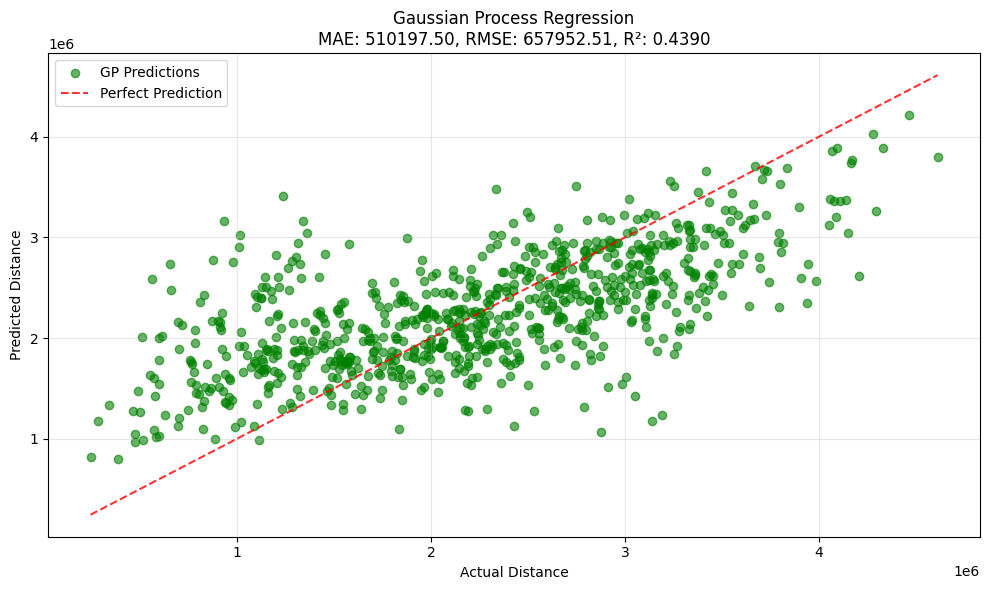

In [138]:
# Visualize GP results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Convert to numpy arrays
y_test_gp_arr = np.array(y_test_gp)
gp_pred_arr = np.array(gp_predictions)

ax.scatter(y_test_gp_arr, gp_pred_arr, alpha=0.6, color="green", label="GP Predictions")
min_val = min(y_test_gp_arr.min(), gp_pred_arr.min())
max_val = max(y_test_gp_arr.max(), gp_pred_arr.max())
ax.plot(
    [min_val, max_val], [min_val, max_val], "r--", alpha=0.8, label="Perfect Prediction"
)
ax.set_xlabel("Actual Distance")
ax.set_ylabel("Predicted Distance")
ax.set_title(
    f"Gaussian Process Regression\nMAE: {gp_mae:.2f}, RMSE: {gp_rmse:.2f}, R²: {gp_r2:.4f}"
)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

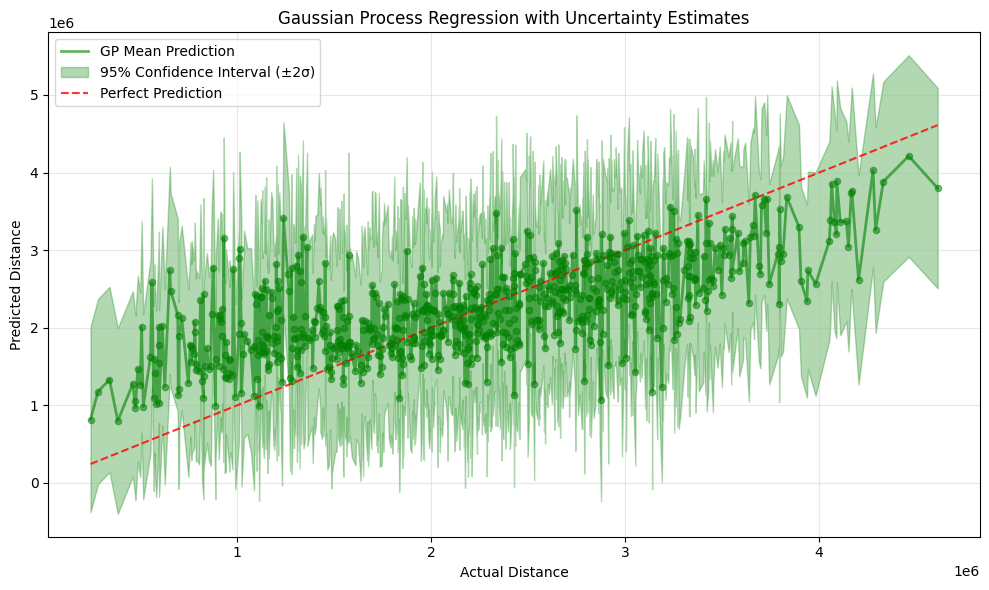

Average prediction uncertainty (std): 632045.04
Min uncertainty: 590228.99
Max uncertainty: 813216.26
Uncertainty as % of mean prediction: 28.04%


In [139]:
# Visualize GP uncertainty estimates
# GP provides predictive uncertainty (standard deviation) which is valuable for understanding prediction confidence
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Sort by actual values for better visualization
sort_idx = np.argsort(y_test_gp_arr)
y_test_sorted = y_test_gp_arr[sort_idx]
gp_pred_sorted = gp_pred_arr[sort_idx]
gp_std_sorted = np.array(gp_std)[sort_idx]

# Plot predictions with uncertainty bands (2 standard deviations = ~95% confidence interval)
ax.plot(
    y_test_sorted,
    gp_pred_sorted,
    "g-",
    alpha=0.6,
    label="GP Mean Prediction",
    linewidth=2,
)
ax.fill_between(
    y_test_sorted,
    gp_pred_sorted - 2 * gp_std_sorted,
    gp_pred_sorted + 2 * gp_std_sorted,
    alpha=0.3,
    color="green",
    label="95% Confidence Interval (±2σ)",
)
ax.scatter(y_test_sorted, gp_pred_sorted, alpha=0.5, color="green", s=20, zorder=3)
ax.plot(
    [y_test_sorted.min(), y_test_sorted.max()],
    [y_test_sorted.min(), y_test_sorted.max()],
    "r--",
    alpha=0.8,
    label="Perfect Prediction",
)
ax.set_xlabel("Actual Distance")
ax.set_ylabel("Predicted Distance")
ax.set_title("Gaussian Process Regression with Uncertainty Estimates")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics about uncertainty
print(f"Average prediction uncertainty (std): {gp_std.mean():.2f}")
print(f"Min uncertainty: {gp_std.min():.2f}")
print(f"Max uncertainty: {gp_std.max():.2f}")
print(
    f"Uncertainty as % of mean prediction: {(gp_std.mean() / gp_pred_arr.mean() * 100):.2f}%"
)

## Neural Networks (MLPs)


In [13]:
# Prepare data for Neural Network Regression
# Create pairwise features from test cases and distance matrix

# Get test cases from valid results
test_cases_nn = [r.test_case for r in valid_results]
features_nn = np.array([testcase_to_ndarray(case) for case in test_cases_nn])

# Create pairwise features and distances
X_nn, y_nn = create_pairwise_features(features_nn, distance_matrix)

print(f"Pairwise features shape: {X_nn.shape}")
print(f"Distances shape: {y_nn.shape}")

# Split data into train/test sets
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn, y_nn, test_size=0.2, random_state=seed
)

print(f"Training set: {X_train_nn.shape[0]} samples")
print(f"Test set: {X_test_nn.shape[0]} samples")

# Normalize features
scaler_nn = StandardScaler()
X_train_nn_scaled = scaler_nn.fit_transform(X_train_nn)
X_test_nn_scaled = scaler_nn.transform(X_test_nn)

Pairwise features shape: (4005, 22)
Distances shape: (4005,)
Training set: 3204 samples
Test set: 801 samples


In [14]:
# Train Multi-Layer Perceptron (MLP) Regressor
# Using a deep neural network with multiple hidden layers

mlp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),  # 3 hidden layers: 128 -> 64 -> 32 neurons
    activation="relu",  # Rectified Linear Unit activation
    solver="adam",  # Adam optimizer
    learning_rate="adaptive",  # Adaptive learning rate
    max_iter=500,  # Maximum iterations
    early_stopping=True,  # Enable early stopping to prevent overfitting
    validation_fraction=0.1,  # 10% of training data for validation
    n_iter_no_change=10,  # Stop if no improvement for 10 iterations
    random_state=seed,
    verbose=True,  # Print training progress
)

print("Training Multi-Layer Perceptron...")
print(f"Training set size: {X_train_nn_scaled.shape[0]} samples")
print(f"Input features: {X_train_nn_scaled.shape[1]}")
print("Architecture: Input -> 128 -> 64 -> 32 -> Output")
print("This may take a few minutes...")

# Fit the model
mlp_model.fit(X_train_nn_scaled, y_train_nn)

print("Training completed!")
print(f"Number of iterations: {mlp_model.n_iter_}")
print(f"Loss: {mlp_model.loss_:.4f}")

Training Multi-Layer Perceptron...
Training set size: 3204 samples
Input features: 22
Architecture: Input -> 128 -> 64 -> 32 -> Output
This may take a few minutes...
Iteration 1, loss = 445962135480.28900146
Validation score: -1.935939
Iteration 2, loss = 445958818197.50366211
Validation score: -1.935904
Iteration 3, loss = 445951126118.82733154
Validation score: -1.935823
Iteration 4, loss = 445933582675.18713379
Validation score: -1.935645
Iteration 5, loss = 445896508419.20281982
Validation score: -1.935279
Iteration 6, loss = 445823594317.36712646
Validation score: -1.934594
Iteration 7, loss = 445693766505.63897705
Validation score: -1.933401
Iteration 8, loss = 445474496255.24566650
Validation score: -1.931445
Iteration 9, loss = 445120153756.37097168
Validation score: -1.928422
Iteration 10, loss = 444579998488.82806396
Validation score: -1.923862
Iteration 11, loss = 443799860274.85406494
Validation score: -1.917296
Iteration 12, loss = 442686378702.26251221
Validation score: -

In [15]:
# Make predictions with MLP model
mlp_predictions = mlp_model.predict(X_test_nn_scaled)

# Calculate metrics
mlp_mae = mean_absolute_error(y_test_nn, mlp_predictions)
mlp_rmse = np.sqrt(mean_squared_error(y_test_nn, mlp_predictions))
mlp_r2 = mlp_model.score(X_test_nn_scaled, y_test_nn)

print("Multi-Layer Perceptron Regression Results:")
print(f"MAE: {mlp_mae:.2f}")
print(f"RMSE: {mlp_rmse:.2f}")
print(f"R squared: {mlp_r2:.4f}")

Multi-Layer Perceptron Regression Results:
MAE: 358261.99
RMSE: 439046.95
R squared: 0.4143


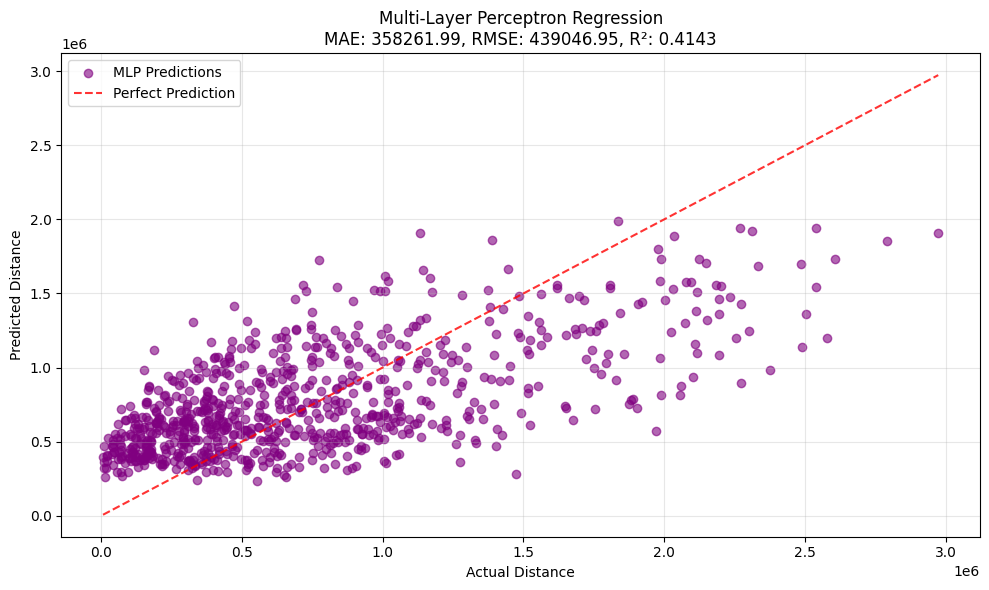

In [16]:
# Visualize MLP results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Convert to numpy arrays
y_test_nn_arr = np.array(y_test_nn)
mlp_pred_arr = np.array(mlp_predictions)

ax.scatter(
    y_test_nn_arr, mlp_pred_arr, alpha=0.6, color="purple", label="MLP Predictions"
)
min_val = min(y_test_nn_arr.min(), mlp_pred_arr.min())
max_val = max(y_test_nn_arr.max(), mlp_pred_arr.max())
ax.plot(
    [min_val, max_val], [min_val, max_val], "r--", alpha=0.8, label="Perfect Prediction"
)
ax.set_xlabel("Actual Distance")
ax.set_ylabel("Predicted Distance")
ax.set_title(
    f"Multi-Layer Perceptron Regression\nMAE: {mlp_mae:.2f}, RMSE: {mlp_rmse:.2f}, R²: {mlp_r2:.4f}"
)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Note: Gaussian Process variables not available. Skipping GP in comparison.


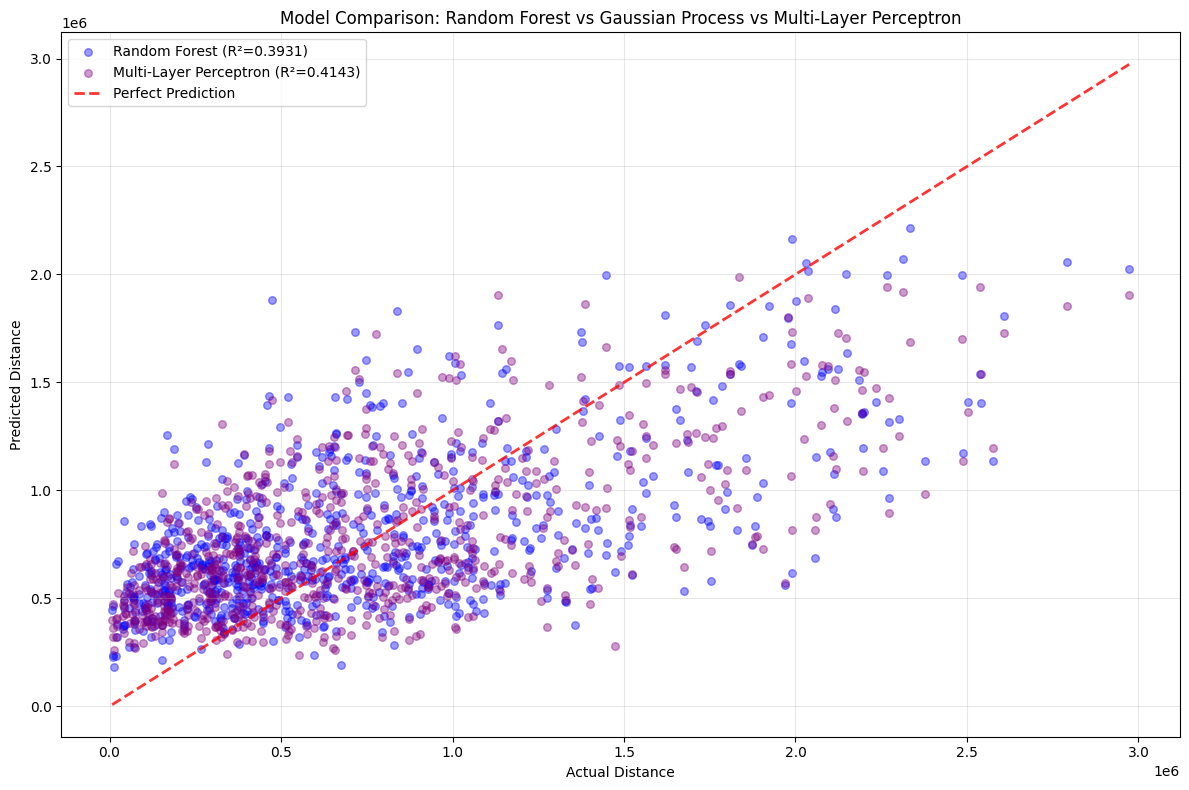


Model Comparison Summary:
Model                     MAE             RMSE            R²             
------------------------------------------------------------
Random Forest             360391.63       446909.12       0.3931         
Multi-Layer Perceptron    358261.99       439046.95       0.4143         


In [17]:
# Compare all three models: Random Forest, Gaussian Process, and Neural Network
# Note: This requires RF and GP variables to be available
# If running independently, comment out this cell or ensure RF/GP sections have been executed

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Get RF and GP predictions if available
try:
    # Random Forest predictions
    ax.scatter(
        y_test,
        rf_predictions,
        alpha=0.4,
        color="blue",
        label=f"Random Forest (R²={rf_r2:.4f})",
        s=30,
    )
except NameError:
    print("Note: Random Forest variables not available. Skipping RF in comparison.")

try:
    # Gaussian Process predictions
    ax.scatter(
        y_test_gp_arr,
        gp_pred_arr,
        alpha=0.4,
        color="green",
        label=f"Gaussian Process (R²={gp_r2:.4f})",
        s=30,
    )
except NameError:
    print("Note: Gaussian Process variables not available. Skipping GP in comparison.")

# Neural Network predictions
ax.scatter(
    y_test_nn_arr,
    mlp_pred_arr,
    alpha=0.4,
    color="purple",
    label=f"Multi-Layer Perceptron (R²={mlp_r2:.4f})",
    s=30,
)

# Perfect prediction line
try:
    all_y = [y_test_nn_arr]
    all_pred = [mlp_pred_arr]
    if "y_test" in globals():
        all_y.append(y_test)
        all_pred.append(rf_predictions)
    if "y_test_gp_arr" in globals():
        all_y.append(y_test_gp_arr)
        all_pred.append(gp_pred_arr)

    min_val = min([arr.min() for arr in all_y] + [arr.min() for arr in all_pred])
    max_val = max([arr.max() for arr in all_y] + [arr.max() for arr in all_pred])
except:
    min_val = min(y_test_nn_arr.min(), mlp_pred_arr.min())
    max_val = max(y_test_nn_arr.max(), mlp_pred_arr.max())

ax.plot(
    [min_val, max_val],
    [min_val, max_val],
    "r--",
    alpha=0.8,
    label="Perfect Prediction",
    linewidth=2,
)
ax.set_xlabel("Actual Distance")
ax.set_ylabel("Predicted Distance")
ax.set_title(
    "Model Comparison: Random Forest vs Gaussian Process vs Multi-Layer Perceptron"
)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison table
print("\nModel Comparison Summary:")
print(f"{'Model':<25} {'MAE':<15} {'RMSE':<15} {'R²':<15}")
print("-" * 60)
try:
    print(f"{'Random Forest':<25} {rf_mae:<15.2f} {rf_rmse:<15.2f} {rf_r2:<15.4f}")
except NameError:
    pass
try:
    print(f"{'Gaussian Process':<25} {gp_mae:<15.2f} {gp_rmse:<15.2f} {gp_r2:<15.4f}")
except NameError:
    pass
print(
    f"{'Multi-Layer Perceptron':<25} {mlp_mae:<15.2f} {mlp_rmse:<15.2f} {mlp_r2:<15.4f}"
)

## Triplet Loss Encoder for Metric Learning


In [ ]:
# Define TripletEncoder neural network
# Architecture: Input (8 dims) -> Linear(64) -> ReLU -> Linear(32) -> ReLU -> Linear(latent_dim)
# Output is L2-normalized latent vector


class TripletEncoder(nn.Module):
    def __init__(
        self, input_dim=8, latent_dim=8, normalize_output=True, dropout_rate=0.4
    ):
        super(TripletEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, latent_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.normalize_output = normalize_output

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        # Optionally L2 normalize the latent vector
        # Note: If distances are all zero, try setting normalize_output=False
        if self.normalize_output:
            x = nn.functional.normalize(x, p=2, dim=1)
        return x

In [ ]:
# Create TripletDataset class for generating anchor-positive-negative triplets
class TripletDataset(Dataset):
    def __init__(
        self,
        features,
        distance_matrix,
        n_triplets,
        positive_threshold_percentile=20,
        negative_threshold_percentile=80,
        random_seed=100,
    ):
        """
        Args:
            features: numpy array of shape (n_samples, n_features)
            distance_matrix: numpy array of shape (n_samples, n_samples) with DTW distances
            n_triplets: number of triplets to generate
            positive_threshold_percentile: percentile threshold for positive examples (lower = closer)
            negative_threshold_percentile: percentile threshold for negative examples (higher = farther)
            random_seed: random seed for reproducibility
        """
        self.features = features
        self.distance_matrix = distance_matrix
        self.n_triplets = n_triplets
        self.n_samples = len(features)

        np.random.seed(random_seed)
        torch.manual_seed(random_seed)

        # Pre-compute thresholds
        # Get all non-zero distances (excluding diagonal)
        mask = ~np.eye(self.n_samples, dtype=bool)
        all_distances = self.distance_matrix[mask]
        self.positive_threshold = np.percentile(
            all_distances, positive_threshold_percentile
        )
        self.negative_threshold = np.percentile(
            all_distances, negative_threshold_percentile
        )

        # Pre-generate triplets
        self.triplets = []
        max_attempts = 1000
        for _ in range(n_triplets):
            anchor_idx = np.random.randint(0, self.n_samples)
            attempts = 0
            positive_idx = None
            negative_idx = None

            # Find positive (similar to anchor)
            while positive_idx is None and attempts < max_attempts:
                candidate = np.random.randint(0, self.n_samples)
                if candidate != anchor_idx:
                    dist = self.distance_matrix[anchor_idx, candidate]
                    if dist <= self.positive_threshold:
                        positive_idx = candidate
                attempts += 1

            # Find negative (dissimilar to anchor)
            attempts = 0
            while negative_idx is None and attempts < max_attempts:
                candidate = np.random.randint(0, self.n_samples)
                if candidate != anchor_idx and candidate != positive_idx:
                    dist = self.distance_matrix[anchor_idx, candidate]
                    if dist >= self.negative_threshold:
                        negative_idx = candidate
                attempts += 1

            if positive_idx is not None and negative_idx is not None:
                self.triplets.append((anchor_idx, positive_idx, negative_idx))
            elif len(self.triplets) > 0:
                # If we can't find valid triplet, reuse a previous one
                self.triplets.append(self.triplets[-1])

        print(f"Generated {len(self.triplets)} valid triplets")
        print(
            f"Positive threshold (percentile {positive_threshold_percentile}): {self.positive_threshold:.2f}"
        )
        print(
            f"Negative threshold (percentile {negative_threshold_percentile}): {self.negative_threshold:.2f}"
        )

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor_idx, positive_idx, negative_idx = self.triplets[idx]
        anchor = torch.FloatTensor(self.features[anchor_idx])
        positive = torch.FloatTensor(self.features[positive_idx])
        negative = torch.FloatTensor(self.features[negative_idx])
        return anchor, positive, negative

In [ ]:
# Implement triplet loss function
def triplet_loss(anchor_emb, positive_emb, negative_emb, margin=0.5):
    """
    Compute triplet loss: max(0, margin + d(anchor, positive) - d(anchor, negative))

    Args:
        anchor_emb: anchor embeddings (batch_size, latent_dim)
        positive_emb: positive embeddings (batch_size, latent_dim)
        negative_emb: negative embeddings (batch_size, latent_dim)
        margin: margin parameter for triplet loss

    Returns:
        Mean triplet loss over batch
    """
    # Compute squared L2 distances
    d_pos = torch.sum((anchor_emb - positive_emb) ** 2, dim=1)
    d_neg = torch.sum((anchor_emb - negative_emb) ** 2, dim=1)

    # Triplet loss: max(0, margin + d_pos - d_neg)
    loss = torch.clamp(margin + d_pos - d_neg, min=0.0)
    return torch.mean(loss)

In [ ]:
# Training function for triplet encoder
def train_triplet_encoder(
    features,
    distance_matrix,
    latent_dim=8,
    margin=0.5,
    epochs=50,
    batch_size=64,
    lr=0.001,
    n_triplets=10000,
    random_seed=100,
    dropout_rate=0.4,
    weight_decay=1e-4,
    features_val=None,
    distance_matrix_val=None,
    patience=10,
    min_delta=1e-6,
):
    """
    Train triplet encoder network.

    Args:
        features: numpy array of shape (n_samples, n_features)
        distance_matrix: numpy array of shape (n_samples, n_samples) with DTW distances
        latent_dim: dimension of latent space (default: 8)
        margin: margin parameter for triplet loss (default: 0.5)
        epochs: number of training epochs (default: 50)
        batch_size: batch size for training (default: 64)
        lr: learning rate (default: 0.001)
        n_triplets: number of triplets to generate (default: 10000)
        random_seed: random seed for reproducibility (default: 100)
        dropout_rate: dropout probability (default: 0.4)
        weight_decay: L2 regularization strength (default: 1e-4)
        features_val: optional validation features for early stopping
        distance_matrix_val: optional validation distance matrix for early stopping
        patience: number of epochs to wait before early stopping (default: 10)
        min_delta: minimum change to qualify as improvement (default: 1e-6)

    Returns:
        trained_encoder: trained TripletEncoder model (best model if early stopping)
        scaler: StandardScaler fitted on features
        loss_history: list of loss values per epoch
    """
    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Normalize validation features if provided
    if features_val is not None:
        features_val_scaled = scaler.transform(features_val)
        # Create validation dataset for early stopping
        val_dataset = TripletDataset(
            features_val_scaled,
            distance_matrix_val,
            min(n_triplets, len(features_val) * (len(features_val) - 1) // 2),
            random_seed=random_seed,
        )
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create dataset and dataloader
    dataset = TripletDataset(
        features_scaled, distance_matrix, n_triplets, random_seed=random_seed
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize encoder
    encoder = TripletEncoder(
        input_dim=features.shape[1], latent_dim=latent_dim, dropout_rate=dropout_rate
    )
    optimizer = optim.Adam(encoder.parameters(), lr=lr, weight_decay=weight_decay)

    # Set random seeds
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)

    # Training loop
    encoder.train()
    loss_history = []
    val_loss_history = []
    best_val_loss = float("inf")
    best_encoder_state = None
    patience_counter = 0

    print(f"Training Triplet Encoder...")
    print(f"  Input dimension: {features.shape[1]}")
    print(f"  Latent dimension: {latent_dim}")
    print(f"  Number of triplets: {len(dataset)}")
    print(f"  Batch size: {batch_size}")
    print(f"  Epochs: {epochs}")
    print(f"  Margin: {margin}")
    print(f"  Dropout rate: {dropout_rate}")
    print(f"  Weight decay: {weight_decay}")
    if features_val is not None:
        print(f"  Early stopping: patience={patience}, min_delta={min_delta}")
    print()

    for epoch in range(epochs):
        epoch_loss = 0.0
        n_batches = 0

        for anchor, positive, negative in dataloader:
            optimizer.zero_grad()

            # Forward pass
            anchor_emb = encoder(anchor)
            positive_emb = encoder(positive)
            negative_emb = encoder(negative)

            # Compute loss
            loss = triplet_loss(anchor_emb, positive_emb, negative_emb, margin=margin)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches if n_batches > 0 else 0.0
        loss_history.append(avg_loss)

        # Compute validation loss if validation set provided
        if features_val is not None:
            encoder.eval()
            val_loss = 0.0
            val_batches = 0
            with torch.no_grad():
                for anchor, positive, negative in val_dataloader:
                    anchor_emb = encoder(anchor)
                    positive_emb = encoder(positive)
                    negative_emb = encoder(negative)
                    loss = triplet_loss(
                        anchor_emb, positive_emb, negative_emb, margin=margin
                    )
                    val_loss += loss.item()
                    val_batches += 1
            avg_val_loss = val_loss / val_batches if val_batches > 0 else 0.0
            val_loss_history.append(avg_val_loss)
            encoder.train()

            # Early stopping check
            if avg_val_loss < best_val_loss - min_delta:
                best_val_loss = avg_val_loss
                best_encoder_state = encoder.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(
                    f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_loss:.6f}, Val Loss: {avg_val_loss:.6f}"
                )

            # Early stopping
            if patience_counter >= patience:
                print(
                    f"\nEarly stopping at epoch {epoch + 1} (no improvement for {patience} epochs)"
                )
                print(f"Best validation loss: {best_val_loss:.6f}")
                encoder.load_state_dict(best_encoder_state)
                break
        else:
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}/{epochs} - Average Loss: {avg_loss:.6f}")

    print(f"\nTraining completed!")
    print(f"Final loss: {loss_history[-1]:.6f}")
    if features_val is not None:
        print(f"Best validation loss: {best_val_loss:.6f}")

    return encoder, scaler, loss_history

In [ ]:
# Encoder-based novelty search function using BallTree
def run_active_coverage_cycles_with_encoder(
    init_cases: list[TestCase],
    cycles: int = 5,
    per_cycle_new: int = 20,
    n_candidates: int = 50000,
    latent_dim: int = 8,
    encoder_epochs: int = 50,
    seed: int = 100,
    cache_distances: bool = True,
):
    """
    Run active coverage cycles using triplet encoder for novelty search.

    Args:
        init_cases: initial test cases to start with
        cycles: number of active learning cycles
        per_cycle_new: number of new test cases to select per cycle
        n_candidates: number of candidate test cases to generate per cycle
        latent_dim: dimension of latent space for encoder
        encoder_epochs: number of epochs to train encoder
        seed: random seed
        cache_distances: whether to cache distance matrix

    Returns:
        results_all: list of all TestResult objects
        trajectories_all: list of all trajectories
        features_all: numpy array of all features
    """
    rng = np.random.default_rng(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Initial setup: evaluate initial cases
    print("=" * 60)
    print("Encoder-Based Active Coverage Cycles")
    print("=" * 60)
    print(f"Initial cases: {len(init_cases)}")

    results_all = evaluate_cases(init_cases)
    valid_results = [r for r in results_all if not r.simulation_failed]
    trajectories = [r.trajectory for r in valid_results]
    test_cases = [r.test_case for r in valid_results]
    features = np.array([testcase_to_ndarray(tc) for tc in test_cases])

    print(f"Valid results: {len(valid_results)}")
    print(f"Features shape: {features.shape}")

    # Compute distance matrix for training encoder
    distance_matrix_file = (
        f"cache/distance_matrix_seed{seed}_size{len(trajectories)}.npy"
    )
    if cache_distances and os.path.exists(distance_matrix_file):
        print(f"Loading distance matrix from {distance_matrix_file}")
        distance_matrix = np.load(distance_matrix_file)
    else:
        print("Computing distance matrix for encoder training...")
        distance_matrix = pairwise_distances(trajectories, distance_type="dtw")
        if cache_distances:
            os.makedirs("cache", exist_ok=True)
            np.save(distance_matrix_file, distance_matrix)
            print(f"Distance matrix saved to {distance_matrix_file}")

    print(f"Distance matrix shape: {distance_matrix.shape}")

    # Train encoder once on initial data
    print("\n" + "=" * 60)
    print("Training Triplet Encoder...")
    print("=" * 60)
    encoder, scaler, loss_history = train_triplet_encoder(
        features,
        distance_matrix,
        latent_dim=latent_dim,
        epochs=encoder_epochs,
        random_seed=seed,
    )

    # Encode all initial conditions
    encoder.eval()
    with torch.no_grad():
        features_scaled = scaler.transform(features)
        features_tensor = torch.FloatTensor(features_scaled)
        latent_vectors = encoder(features_tensor).numpy()

    print(f"\nEncoded {len(latent_vectors)} initial conditions to latent space")
    print(f"Latent vectors shape: {latent_vectors.shape}")

    # Build initial BallTree
    balltree = BallTree(latent_vectors)
    print("Built BallTree for efficient nearest neighbor search")

    # Active learning loop
    print("\n" + "=" * 60)
    print("Starting Active Learning Cycles")
    print("=" * 60)

    for c in range(1, cycles + 1):
        print(f"\n[Cycle {c}/{cycles}]")

        # Generate random candidate initial conditions
        feat_min = features.min(axis=0)
        feat_max = features.max(axis=0)
        candidates = rng.uniform(
            low=feat_min, high=feat_max, size=(n_candidates, features.shape[1])
        )

        # Encode candidates
        candidates_scaled = scaler.transform(candidates)
        candidates_tensor = torch.FloatTensor(candidates_scaled)

        encoder.eval()
        with torch.no_grad():
            candidate_latent = encoder(candidates_tensor).numpy()

        # Find minimum distance from each candidate to existing set
        distances, _ = balltree.query(candidate_latent, k=1)
        min_distances = distances.flatten()

        # Select candidates with maximum minimum distance (most novel)
        # Select top per_cycle_new candidates
        top_indices = np.argsort(min_distances)[-per_cycle_new:][::-1]
        selected_candidates = candidates[top_indices]

        # Convert to TestCase objects
        new_cases = [ndarray_to_testcase(cand) for cand in selected_candidates]

        # Evaluate new cases
        new_results = evaluate_cases(new_cases)
        new_valid = [r for r in new_results if not r.simulation_failed]

        if len(new_valid) == 0:
            print(f"  Warning: No valid results in cycle {c}, skipping...")
            continue

        # Add to results
        results_all.extend(new_results)
        new_trajectories = [r.trajectory for r in new_valid]
        new_test_cases = [r.test_case for r in new_valid]
        new_features = np.array([testcase_to_ndarray(tc) for tc in new_test_cases])

        # Encode new valid cases and add to BallTree
        new_features_scaled = scaler.transform(new_features)
        new_features_tensor = torch.FloatTensor(new_features_scaled)

        encoder.eval()
        with torch.no_grad():
            new_latent = encoder(new_features_tensor).numpy()

        # Update BallTree by rebuilding (BallTree doesn't support incremental updates)
        latent_vectors = np.vstack([latent_vectors, new_latent])
        balltree = BallTree(latent_vectors)

        # Update tracking variables
        trajectories.extend(new_trajectories)
        test_cases.extend(new_test_cases)
        features = np.vstack([features, new_features])

        print(f"  Selected {per_cycle_new} candidates")
        print(f"  Valid new results: {len(new_valid)}")
        print(
            f"  Total valid results: {len([r for r in results_all if not r.simulation_failed])}"
        )
        print(f"  Average novelty distance: {min_distances[top_indices].mean():.4f}")

    print("\n" + "=" * 60)
    print("Active Learning Completed")
    print("=" * 60)

    trajectories_all = [r.trajectory for r in results_all if not r.simulation_failed]
    features_all = np.array(
        [
            testcase_to_ndarray(r.test_case)
            for r in results_all
            if not r.simulation_failed
        ]
    )

    return results_all, trajectories_all, features_all

Training encoder for visualization...
Generated 5000 valid triplets
Positive threshold (percentile 20): 1459260.05
Negative threshold (percentile 80): 3002778.31
Training Triplet Encoder...
  Input dimension: 8
  Latent dimension: 8
  Number of triplets: 5000
  Batch size: 64
  Epochs: 30
  Margin: 0.5
  Dropout rate: 0.4
  Weight decay: 0.0001

Epoch 1/30 - Average Loss: 0.441807
Epoch 10/30 - Average Loss: 0.108067
Epoch 20/30 - Average Loss: 0.049711
Epoch 30/30 - Average Loss: 0.033545

Training completed!
Final loss: 0.033545


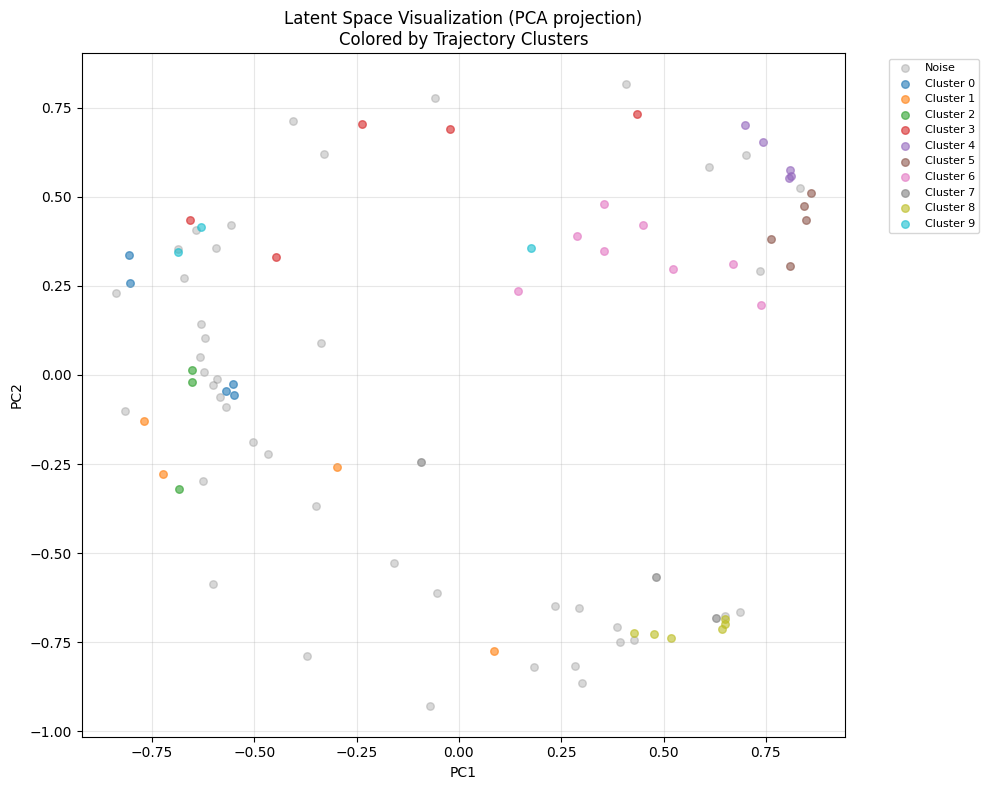

PCA Explained Variance: PC1=44.57%, PC2=35.05%
Total explained variance: 79.62%


In [ ]:
# Visualize latent space using PCA
# First, we need to train the encoder and encode the data
# This cell assumes valid_results, distance_matrix, and testcase_to_ndarray are available

# Extract features
test_cases_enc = [r.test_case for r in valid_results]
features_enc = np.array([testcase_to_ndarray(case) for case in test_cases_enc])

# Train encoder (using fewer epochs for quick visualization)
print("Training encoder for visualization...")
encoder_viz, scaler_viz, loss_history_viz = train_triplet_encoder(
    features_enc,
    distance_matrix,
    latent_dim=8,
    epochs=30,  # Fewer epochs for quick demo
    n_triplets=5000,
    random_seed=seed,
)

# Encode all features
encoder_viz.eval()
with torch.no_grad():
    features_scaled_viz = scaler_viz.transform(features_enc)
    features_tensor_viz = torch.FloatTensor(features_scaled_viz)
    latent_vectors_viz = encoder_viz(features_tensor_viz).numpy()

# Use PCA to project to 2D for visualization
from sklearn.decomposition import PCA

pca_viz = PCA(n_components=2)
latent_2d = pca_viz.fit_transform(latent_vectors_viz)

# Color by trajectory clusters (from earlier OPTICS clustering)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
colors_cluster = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

for cluster_id in unique_clusters:
    mask = clusters == cluster_id
    if cluster_id == -1:
        ax.scatter(
            latent_2d[mask, 0],
            latent_2d[mask, 1],
            c="gray",
            alpha=0.3,
            s=30,
            label="Noise",
        )
    else:
        ax.scatter(
            latent_2d[mask, 0],
            latent_2d[mask, 1],
            c=[colors_cluster[cluster_id % len(colors_cluster)]],
            alpha=0.6,
            s=30,
            label=f"Cluster {cluster_id}",
        )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title(
    "Latent Space Visualization (PCA projection)\nColored by Trajectory Clusters"
)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(
    f"PCA Explained Variance: PC1={pca_viz.explained_variance_ratio_[0]:.2%}, PC2={pca_viz.explained_variance_ratio_[1]:.2%}"
)
print(f"Total explained variance: {pca_viz.explained_variance_ratio_.sum():.2%}")

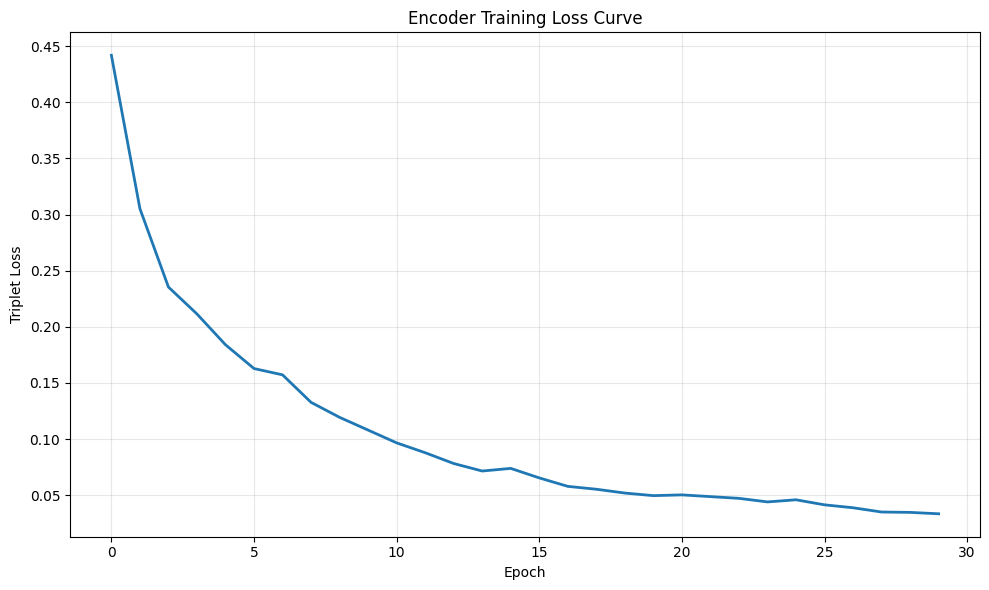

Initial loss: 0.441807
Final loss: 0.033545
Loss reduction: 92.41%


In [ ]:
# Plot training loss curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(loss_history_viz, linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Triplet Loss")
ax.set_title("Encoder Training Loss Curve")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial loss: {loss_history_viz[0]:.6f}")
print(f"Final loss: {loss_history_viz[-1]:.6f}")
print(
    f"Loss reduction: {(loss_history_viz[0] - loss_history_viz[-1]) / loss_history_viz[0] * 100:.2f}%"
)

Latent vectors shape: (90, 8)
Sample latent vector norms: [1.         0.99999994 1.         1.         0.99999994]
Latent vector stats:
  Min: -0.846951, Max: 0.916443
  Mean: -0.032408, Std: 0.352065
  First few vectors (first 3 dims):
    Vector 0: [-0.25592652  0.34598833 -0.3095338 ]
    Vector 1: [ 0.14884415  0.3486717  -0.35848016]
    Vector 2: [-0.12470825  0.35988337 -0.45026258]
    Vector 3: [ 0.22926863  0.00314575 -0.7037494 ]
    Vector 4: [-0.07212211  0.4644823  -0.24621059]

Distance Statistics:
DTW distances:
  Min: 135559.18, Max: 4346730.06
  Mean: 2254190.65, Median: 2292903.37
  Std: 829600.10

Latent distances:
  Min: 0.064644, Max: 1.902494
  Mean: 1.144786, Median: 1.250154
  Std: 0.441266

Sample pairs (first 10):
  Pair (8, 24): DTW=2965724.03, Latent=1.151416
  Pair (67, 87): DTW=987525.05, Latent=0.922228
  Pair (79, 48): DTW=2042759.89, Latent=1.281482
  Pair (10, 52): DTW=2884353.78, Latent=1.414450
  Pair (53, 66): DTW=1335398.75, Latent=1.179289
  Pair

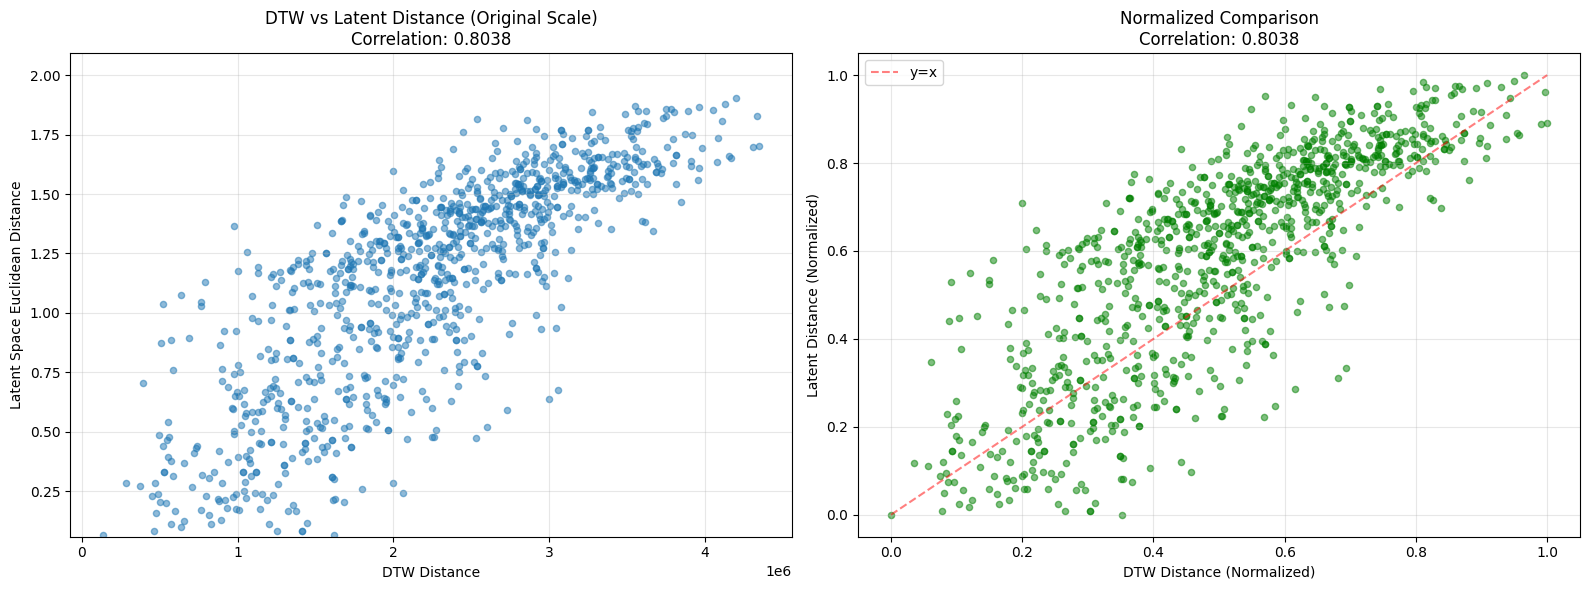


Correlation between DTW and latent distances: 0.8038

Note: Latent distances are much smaller than DTW distances because:
  - Latent vectors are L2-normalized (unit length)
  - Euclidean distance between normalized vectors ranges from 0 to 2
  - The correlation shows the relationship, not the absolute scale


In [ ]:
# Compare DTW distances vs latent space Euclidean distances
# Sample pairs for comparison (to avoid too many points)
n_pairs = 1000
np.random.seed(seed)

# Generate random pairs (i, j) where i != j
# Adjust n_pairs if dataset is too small
max_pairs = len(features_enc) * (len(features_enc) - 1) // 2
n_pairs = min(n_pairs, max_pairs)

pair_indices = []
attempts = 0
max_attempts = n_pairs * 10

while len(pair_indices) < n_pairs and attempts < max_attempts:
    i = np.random.randint(0, len(features_enc))
    j = np.random.randint(0, len(features_enc))
    if i != j and (i, j) not in pair_indices:
        pair_indices.append((i, j))
    attempts += 1

pair_indices = np.array(pair_indices)

# Debug: Check latent vectors
print(f"Latent vectors shape: {latent_vectors_viz.shape}")
print(f"Sample latent vector norms: {np.linalg.norm(latent_vectors_viz[:5], axis=1)}")
print(f"Latent vector stats:")
print(f"  Min: {latent_vectors_viz.min():.6f}, Max: {latent_vectors_viz.max():.6f}")
print(f"  Mean: {latent_vectors_viz.mean():.6f}, Std: {latent_vectors_viz.std():.6f}")
print(f"  First few vectors (first 3 dims):")
for idx in range(min(5, len(latent_vectors_viz))):
    print(f"    Vector {idx}: {latent_vectors_viz[idx][:3]}")

dtw_distances = []
latent_distances = []

for i, j in pair_indices:
    # DTW distance
    dtw_dist = distance_matrix[i, j]
    dtw_distances.append(dtw_dist)

    # Latent space Euclidean distance
    # Since vectors are L2-normalized, distance ranges from 0 to 2
    # Distance = sqrt(2 - 2*cos(angle)) = sqrt(2*(1 - dot_product))
    vec_i = latent_vectors_viz[i]
    vec_j = latent_vectors_viz[j]
    latent_dist = np.linalg.norm(vec_i - vec_j)
    latent_distances.append(latent_dist)

dtw_distances = np.array(dtw_distances)
latent_distances = np.array(latent_distances)

# Print detailed statistics
print(f"\nDistance Statistics:")
print(f"DTW distances:")
print(f"  Min: {dtw_distances.min():.2f}, Max: {dtw_distances.max():.2f}")
print(f"  Mean: {dtw_distances.mean():.2f}, Median: {np.median(dtw_distances):.2f}")
print(f"  Std: {dtw_distances.std():.2f}")
print(f"\nLatent distances:")
print(f"  Min: {latent_distances.min():.6f}, Max: {latent_distances.max():.6f}")
print(
    f"  Mean: {latent_distances.mean():.6f}, Median: {np.median(latent_distances):.6f}"
)
print(f"  Std: {latent_distances.std():.6f}")
print(f"\nSample pairs (first 10):")
for idx in range(min(10, len(pair_indices))):
    i, j = pair_indices[idx]
    print(
        f"  Pair ({i}, {j}): DTW={dtw_distances[idx]:.2f}, Latent={latent_distances[idx]:.6f}"
    )

# Compute correlation
correlation = np.corrcoef(dtw_distances, latent_distances)[0, 1]

# Plot comparison with proper scaling
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Original scales (shows latent distances are small but non-zero)
ax1 = axes[0]
ax1.scatter(dtw_distances, latent_distances, alpha=0.5, s=20)
ax1.set_xlabel("DTW Distance")
ax1.set_ylabel("Latent Space Euclidean Distance")
ax1.set_title(
    f"DTW vs Latent Distance (Original Scale)\nCorrelation: {correlation:.4f}"
)
ax1.grid(True, alpha=0.3)
# Set y-axis to show small values clearly
if latent_distances.max() > 0:
    ax1.set_ylim([latent_distances.min() * 0.9, latent_distances.max() * 1.1])

# Right plot: Normalized to [0, 1] for better comparison
ax2 = axes[1]
# Normalize both distances to [0, 1] for fair comparison
dtw_norm = (dtw_distances - dtw_distances.min()) / (
    dtw_distances.max() - dtw_distances.min() + 1e-10
)
latent_norm = (latent_distances - latent_distances.min()) / (
    latent_distances.max() - latent_distances.min() + 1e-10
)
ax2.scatter(dtw_norm, latent_norm, alpha=0.5, s=20, color="green")
ax2.set_xlabel("DTW Distance (Normalized)")
ax2.set_ylabel("Latent Distance (Normalized)")
ax2.set_title(f"Normalized Comparison\nCorrelation: {correlation:.4f}")
ax2.grid(True, alpha=0.3)
# Add diagonal line for normalized plot
ax2.plot([0, 1], [0, 1], "r--", alpha=0.5, label="y=x")
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nCorrelation between DTW and latent distances: {correlation:.4f}")
print(f"\nNote: Latent distances are much smaller than DTW distances because:")
print(f"  - Latent vectors are L2-normalized (unit length)")
print(f"  - Euclidean distance between normalized vectors ranges from 0 to 2")
print(f"  - The correlation shows the relationship, not the absolute scale")

## Distance Prediction Evaluation: Encoder vs Traditional Models

Compare the triplet encoder's ability to predict trajectory distances with Random Forest, Gaussian Process, and MLP models on a held-out test set.


In [ ]:
# Prepare data for train/test evaluation
# Extract features and create pairwise features for distance prediction

# Extract initial conditions
test_cases_eval = [r.test_case for r in valid_results]
features_eval = np.array([testcase_to_ndarray(case) for case in test_cases_eval])

# Create pairwise features and distances
X_pairwise, y_distances = create_pairwise_features(features_eval, distance_matrix)

print(f"Total samples: {len(features_eval)}")
print(f"Pairwise features shape: {X_pairwise.shape}")
print(f"Distances shape: {y_distances.shape}")

# Split into train/test sets (80/20 split)
# We split at the individual sample level, then create pairwise features
# This ensures no data leakage between train and test
train_indices, test_indices = train_test_split(
    np.arange(len(features_eval)), test_size=0.2, random_state=seed
)

print(f"\nTrain set: {len(train_indices)} samples")
print(f"Test set: {len(test_indices)} samples")

# Create train/test pairwise features
# Only pairs where both samples are in the same set
train_pairs = []
test_pairs = []
train_distances = []
test_distances = []

for i in range(len(features_eval)):
    for j in range(i + 1, len(features_eval)):
        if i in train_indices and j in train_indices:
            # Both in train set
            pair_idx = len(features_eval) * i - i * (i + 1) // 2 + j - i - 1
            train_pairs.append(pair_idx)
            train_distances.append(distance_matrix[i, j])
        elif i in test_indices and j in test_indices:
            # Both in test set
            pair_idx = len(features_eval) * i - i * (i + 1) // 2 + j - i - 1
            test_pairs.append(pair_idx)
            test_distances.append(distance_matrix[i, j])

X_train_pairwise = X_pairwise[train_pairs]
y_train_distances = np.array(train_distances)
X_test_pairwise = X_pairwise[test_pairs]
y_test_distances = np.array(test_distances)

print(f"\nTrain pairwise samples: {len(train_pairs)}")
print(f"Test pairwise samples: {len(test_pairs)}")

# Also keep track of train/test features for encoder
features_train = features_eval[train_indices]
features_test = features_eval[test_indices]
distance_matrix_train = distance_matrix[np.ix_(train_indices, train_indices)]
distance_matrix_test = distance_matrix[np.ix_(test_indices, test_indices)]

print(f"\nTrain features shape: {features_train.shape}")
print(f"Test features shape: {features_test.shape}")

Total samples: 90
Pairwise features shape: (4005, 22)
Distances shape: (4005,)

Train set: 72 samples
Test set: 18 samples

Train pairwise samples: 2556
Test pairwise samples: 153

Train features shape: (72, 8)
Test features shape: (18, 8)


In [ ]:
# Train Triplet Encoder on training set
print("=" * 60)
print("Training Triplet Encoder on Training Set")
print("=" * 60)


# Add validation: check correlation during training
def train_triplet_encoder_with_validation(
    features_train,
    distance_matrix_train,
    features_val,
    distance_matrix_val,
    latent_dim=8,
    margin=0.5,
    epochs=50,
    batch_size=64,
    lr=0.001,
    n_triplets=10000,
    random_seed=100,
    dropout_rate=0.4,
    weight_decay=1e-4,
    patience=10,
    min_delta=1e-6,
):
    """
    Train triplet encoder with validation monitoring and early stopping.

    Args:
        features_train: numpy array of shape (n_samples, n_features) for training
        distance_matrix_train: numpy array of shape (n_samples, n_samples) with DTW distances for training
        features_val: numpy array of shape (n_val_samples, n_features) for validation
        distance_matrix_val: numpy array of shape (n_val_samples, n_val_samples) with DTW distances for validation
        latent_dim: dimension of latent space (default: 8)
        margin: margin parameter for triplet loss (default: 0.5)
        epochs: maximum number of training epochs (default: 50)
        batch_size: batch size for training (default: 64)
        lr: learning rate (default: 0.001)
        n_triplets: number of triplets to generate (default: 10000)
        random_seed: random seed for reproducibility (default: 100)
        dropout_rate: dropout probability (default: 0.4)
        weight_decay: L2 regularization strength (default: 1e-4)
        patience: number of epochs to wait before early stopping (default: 10)
        min_delta: minimum change to qualify as improvement (default: 1e-6)

    Returns:
        encoder: best TripletEncoder model (lowest validation loss)
        scaler: StandardScaler fitted on training features
        loss_history: list of training loss values per epoch
        val_correlations: list of validation correlations per evaluation epoch
    """
    scaler = StandardScaler()
    features_train_scaled = scaler.fit_transform(features_train)
    features_val_scaled = scaler.transform(features_val)

    dataset = TripletDataset(
        features_train_scaled,
        distance_matrix_train,
        n_triplets,
        random_seed=random_seed,
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Create validation dataset for early stopping
    val_dataset = TripletDataset(
        features_val_scaled,
        distance_matrix_val,
        min(n_triplets, len(features_val) * (len(features_val) - 1) // 2),
        random_seed=random_seed,
    )
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    encoder = TripletEncoder(
        input_dim=features_train.shape[1],
        latent_dim=latent_dim,
        dropout_rate=dropout_rate,
    )
    optimizer = optim.Adam(encoder.parameters(), lr=lr, weight_decay=weight_decay)

    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)

    encoder.train()
    loss_history = []
    val_loss_history = []
    val_correlations = []
    best_val_loss = float("inf")
    best_encoder_state = None
    patience_counter = 0

    print(f"Training Triplet Encoder with Validation...")
    print(f"  Train samples: {len(features_train)}, Val samples: {len(features_val)}")
    print(f"  Latent dimension: {latent_dim}, Epochs: {epochs}")
    print(f"  Dropout rate: {dropout_rate}")
    print(f"  Weight decay: {weight_decay}")
    print(f"  Early stopping: patience={patience}, min_delta={min_delta}")
    print()

    for epoch in range(epochs):
        epoch_loss = 0.0
        n_batches = 0

        for anchor, positive, negative in dataloader:
            optimizer.zero_grad()
            anchor_emb = encoder(anchor)
            positive_emb = encoder(positive)
            negative_emb = encoder(negative)
            loss = triplet_loss(anchor_emb, positive_emb, negative_emb, margin=margin)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches if n_batches > 0 else 0.0
        loss_history.append(avg_loss)

        # Compute validation loss and correlation
        encoder.eval()
        val_loss = 0.0
        val_batches = 0
        with torch.no_grad():
            # Compute validation triplet loss
            for anchor, positive, negative in val_dataloader:
                anchor_emb = encoder(anchor)
                positive_emb = encoder(positive)
                negative_emb = encoder(negative)
                loss = triplet_loss(
                    anchor_emb, positive_emb, negative_emb, margin=margin
                )
                val_loss += loss.item()
                val_batches += 1

            # Compute validation correlation
            latent_val = encoder(torch.FloatTensor(features_val_scaled)).numpy()
            n_val = len(features_val)
            val_latent_dists = []
            val_true_dists = []
            for i in range(n_val):
                for j in range(i + 1, n_val):
                    val_latent_dists.append(
                        np.linalg.norm(latent_val[i] - latent_val[j])
                    )
                    val_true_dists.append(distance_matrix_val[i, j])
            val_corr = np.corrcoef(val_latent_dists, val_true_dists)[0, 1]

        avg_val_loss = val_loss / val_batches if val_batches > 0 else 0.0
        val_loss_history.append(avg_val_loss)
        val_correlations.append(val_corr)
        encoder.train()

        # Early stopping check based on validation loss
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss
            best_encoder_state = encoder.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(
                f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_loss:.6f}, Val Loss: {avg_val_loss:.6f}, Val Correlation: {val_corr:.4f}"
            )

        # Early stopping
        if patience_counter >= patience:
            print(
                f"\nEarly stopping at epoch {epoch + 1} (no improvement for {patience} epochs)"
            )
            print(f"Best validation loss: {best_val_loss:.6f}")
            encoder.load_state_dict(best_encoder_state)
            break

    print(f"\nTraining completed!")
    print(f"Final loss: {loss_history[-1]:.6f}")
    print(f"Best validation loss: {best_val_loss:.6f}")
    print(f"Final validation correlation: {val_correlations[-1]:.4f}")

    return encoder, scaler, loss_history, val_correlations


# Split training set further for validation
train_indices_final, val_indices = train_test_split(
    train_indices, test_size=0.2, random_state=seed
)

features_train_final = features_eval[train_indices_final]
features_val = features_eval[val_indices]
distance_matrix_train_final = distance_matrix[
    np.ix_(train_indices_final, train_indices_final)
]
distance_matrix_val = distance_matrix[np.ix_(val_indices, val_indices)]

encoder_eval, scaler_eval, loss_history_eval, val_correlations = (
    train_triplet_encoder_with_validation(
        features_train_final,
        distance_matrix_train_final,
        features_val,
        distance_matrix_val,
        latent_dim=8,
        epochs=50,
        n_triplets=10000,
        random_seed=seed,
    )
)

# Update features_train to use the final training set
features_train = features_train_final
distance_matrix_train = distance_matrix_train_final

# Encode train and test features
encoder_eval.eval()
with torch.no_grad():
    features_train_scaled = scaler_eval.transform(features_train)
    features_test_scaled = scaler_eval.transform(features_test)

    features_train_tensor = torch.FloatTensor(features_train_scaled)
    features_test_tensor = torch.FloatTensor(features_test_scaled)

    latent_train = encoder_eval(features_train_tensor).numpy()
    latent_test = encoder_eval(features_test_tensor).numpy()

print(f"\nEncoded train features: {latent_train.shape}")
print(f"Encoded test features: {latent_test.shape}")


# Function to predict distances using encoder
def predict_distances_encoder(latent_vectors, indices_i, indices_j):
    """Predict distances using encoder latent space Euclidean distance"""
    latent_i = latent_vectors[indices_i]
    latent_j = latent_vectors[indices_j]
    distances = np.linalg.norm(latent_i - latent_j, axis=1)
    return distances


# Diagnostic: Check if embeddings are collapsing
print(f"\nLatent space diagnostics:")
print(
    f"  Train latent norms - Min: {np.linalg.norm(latent_train, axis=1).min():.4f}, "
    f"Max: {np.linalg.norm(latent_train, axis=1).max():.4f}, "
    f"Mean: {np.linalg.norm(latent_train, axis=1).mean():.4f}"
)
print(f"  Train latent std per dimension: {latent_train.std(axis=0).mean():.4f}")
print(f"  Test latent std per dimension: {latent_test.std(axis=0).mean():.4f}")

# Check correlation on training set
train_i_indices_diag = []
train_j_indices_diag = []
train_true_dists_diag = []
for i in range(len(features_train)):
    for j in range(i + 1, len(features_train)):
        train_i_indices_diag.append(i)
        train_j_indices_diag.append(j)
        train_true_dists_diag.append(distance_matrix_train[i, j])

train_latent_dists_diag = predict_distances_encoder(
    latent_train, np.array(train_i_indices_diag), np.array(train_j_indices_diag)
)
train_corr_diag = np.corrcoef(train_latent_dists_diag, train_true_dists_diag)[0, 1]
print(f"\nTraining set correlation (raw latent distances): {train_corr_diag:.4f}")

# Map test pairwise indices back to original test indices
# We need to find which pairs in test_pairs correspond to which test samples
test_indices_map = {idx: i for i, idx in enumerate(test_indices)}

test_i_indices = []
test_j_indices = []
for i in test_indices:
    for j in test_indices:
        if i < j:
            test_i_indices.append(test_indices_map[i])
            test_j_indices.append(test_indices_map[j])

test_i_indices = np.array(test_i_indices)
test_j_indices = np.array(test_j_indices)

# Predict distances using encoder
y_test_pred_encoder = predict_distances_encoder(
    latent_test, test_i_indices, test_j_indices
)

# Scale encoder predictions to match DTW distance scale
# Use linear regression to map latent distances to DTW distances on training set
from sklearn.linear_model import LinearRegression

# Generate pairs for training set (use indices 0 to len(features_train)-1)
train_i_indices = []
train_j_indices = []
n_train = len(features_train)
for i in range(n_train):
    for j in range(i + 1, n_train):
        train_i_indices.append(i)
        train_j_indices.append(j)

train_i_indices = np.array(train_i_indices)
train_j_indices = np.array(train_j_indices)

y_train_pred_encoder_raw = predict_distances_encoder(
    latent_train, train_i_indices, train_j_indices
)

# Get true training distances for scaling (matching the pairs we computed)
y_train_distances_for_scaling = []
for i in range(n_train):
    for j in range(i + 1, n_train):
        y_train_distances_for_scaling.append(distance_matrix_train[i, j])
y_train_distances_for_scaling = np.array(y_train_distances_for_scaling)

# Fit scaler to map latent distances to DTW distances
distance_scaler = LinearRegression()
distance_scaler.fit(
    y_train_pred_encoder_raw.reshape(-1, 1), y_train_distances_for_scaling
)
y_test_pred_encoder_scaled = distance_scaler.predict(
    y_test_pred_encoder.reshape(-1, 1)
).flatten()

# Also compute training correlation after scaling
y_train_pred_encoder_scaled_train = distance_scaler.predict(
    y_train_pred_encoder_raw.reshape(-1, 1)
).flatten()

print(
    f"\nEncoder predictions (raw) - Min: {y_test_pred_encoder.min():.4f}, Max: {y_test_pred_encoder.max():.4f}"
)
print(
    f"Encoder predictions (scaled) - Min: {y_test_pred_encoder_scaled.min():.2f}, Max: {y_test_pred_encoder_scaled.max():.2f}"
)
print(
    f"True distances - Min: {y_test_distances.min():.2f}, Max: {y_test_distances.max():.2f}"
)

# Compare correlations across splits
train_corr_scaled = np.corrcoef(
    y_train_pred_encoder_scaled_train, y_train_distances_for_scaling
)[0, 1]
print(f"\n" + "=" * 60)
print("Correlation Summary Across Splits:")
print("=" * 60)
print(f"Training set correlation (raw):      {train_corr_diag:.4f}")
print(f"Training set correlation (scaled):  {train_corr_scaled:.4f}")
print(f"Validation set correlation:         {val_correlations[-1]:.4f}")
print(
    f"\n⚠️  Large gap between train ({train_corr_diag:.4f}) and validation ({val_correlations[-1]:.4f}) suggests overfitting!"
)

Training Triplet Encoder on Training Set
Generated 10000 valid triplets
Positive threshold (percentile 20): 1450204.70
Negative threshold (percentile 80): 2964627.26
Generated 105 valid triplets
Positive threshold (percentile 20): 1448060.70
Negative threshold (percentile 80): 2780961.01
Training Triplet Encoder with Validation...
  Train samples: 57, Val samples: 15
  Latent dimension: 8, Epochs: 50
  Dropout rate: 0.4
  Weight decay: 0.0001
  Early stopping: patience=10, min_delta=1e-06

Epoch 1/50 - Train Loss: 0.326008, Val Loss: 0.425965, Val Correlation: 0.3438
Epoch 10/50 - Train Loss: 0.029039, Val Loss: 0.251505, Val Correlation: 0.4488
Epoch 20/50 - Train Loss: 0.014670, Val Loss: 0.145018, Val Correlation: 0.4509

Early stopping at epoch 25 (no improvement for 10 epochs)
Best validation loss: 0.125786

Training completed!
Final loss: 0.013541
Best validation loss: 0.125786
Final validation correlation: 0.4524

Encoded train features: (57, 8)
Encoded test features: (18, 8)

L

In [ ]:
# Train Random Forest on training set
print("=" * 60)
print("Training Random Forest on Training Set")
print("=" * 60)

scaler_rf_eval = StandardScaler()
X_train_rf_scaled = scaler_rf_eval.fit_transform(X_train_pairwise)
X_test_rf_scaled = scaler_rf_eval.transform(X_test_pairwise)

rf_model_eval = RandomForestRegressor(
    n_estimators=100, max_depth=20, random_state=seed, n_jobs=-1
)

rf_model_eval.fit(X_train_rf_scaled, y_train_distances)
y_test_pred_rf = rf_model_eval.predict(X_test_rf_scaled)

print("Random Forest training completed!")

Training Random Forest on Training Set
Random Forest training completed!


In [ ]:
# Train Gaussian Process on training set (subsampled for speed)
print("=" * 60)
print("Training Gaussian Process on Training Set")
print("=" * 60)

# Subsample training data for GP (GP is O(n³))
max_gp_samples = 2000
if len(X_train_pairwise) > max_gp_samples:
    gp_indices = np.random.choice(
        len(X_train_pairwise), size=max_gp_samples, replace=False
    )
    X_train_gp = X_train_pairwise[gp_indices]
    y_train_gp = y_train_distances[gp_indices]
else:
    X_train_gp = X_train_pairwise
    y_train_gp = y_train_distances

scaler_gp_eval = StandardScaler()
X_train_gp_scaled = scaler_gp_eval.fit_transform(X_train_gp)
X_test_gp_scaled = scaler_gp_eval.transform(X_test_pairwise)

# Define GP kernel
kernel_gp_eval = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(
    noise_level=0.1
)

gp_model_eval = GaussianProcessRegressor(
    kernel=kernel_gp_eval,
    n_restarts_optimizer=5,
    random_state=seed,
)

gp_model_eval.fit(X_train_gp_scaled, y_train_gp)
y_test_pred_gp, y_test_std_gp = gp_model_eval.predict(X_test_gp_scaled, return_std=True)

print(f"Gaussian Process training completed! (trained on {len(X_train_gp)} samples)")

Training Gaussian Process on Training Set
Gaussian Process training completed! (trained on 2000 samples)


/Users/y65ng/Developer/unc/research/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/y65ng/Developer/unc/research/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
# Train MLP on training set
print("=" * 60)
print("Training MLP on Training Set")
print("=" * 60)

scaler_mlp_eval = StandardScaler()
X_train_mlp_scaled = scaler_mlp_eval.fit_transform(X_train_pairwise)
X_test_mlp_scaled = scaler_mlp_eval.transform(X_test_pairwise)

mlp_model_eval = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    max_iter=500,
    early_stopping=True,
    random_state=seed,
)

mlp_model_eval.fit(X_train_mlp_scaled, y_train_distances)
y_test_pred_mlp = mlp_model_eval.predict(X_test_mlp_scaled)

print("MLP training completed!")

Training MLP on Training Set
MLP training completed!


/Users/y65ng/Developer/unc/research/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Evaluate all models on test set
print("=" * 60)
print("Model Evaluation on Test Set")
print("=" * 60)


def evaluate_predictions(y_true, y_pred, model_name):
    """Evaluate predictions and return metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
    correlation = np.corrcoef(y_true, y_pred)[0, 1]

    # Calculate baseline (mean predictor) error for comparison
    baseline_error = np.sum((y_true - np.mean(y_true)) ** 2)
    model_error = np.sum((y_true - y_pred) ** 2)

    print(f"\n{model_name}:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  Correlation: {correlation:.4f}")

    # Additional diagnostics for negative R²
    if r2 < 0:
        print(
            f"  ⚠️  Negative R²: Model error ({model_error:.2e}) > Baseline error ({baseline_error:.2e})"
        )
        print(
            f"     This means predicting the mean ({np.mean(y_true):.2f}) would be better!"
        )
        print(
            f"     Correlation is positive ({correlation:.4f}) but predictions are systematically biased."
        )

    return {"mae": mae, "rmse": rmse, "r2": r2, "correlation": correlation}


# First, evaluate encoder with RAW latent distances (to show inherent performance)
print("\n" + "-" * 60)
print("Note: Encoder produces latent space distances (0-2 range)")
print("Other models predict DTW distances directly (much larger scale)")
print("-" * 60)

results_encoder_raw = evaluate_predictions(
    y_test_distances, y_test_pred_encoder, "Triplet Encoder (raw latent distances)"
)

print("\n" + "-" * 60)
print("Scaling encoder predictions to DTW scale for fair comparison...")
print("(This preserves the relative ordering and correlation)")
print("-" * 60)

# Evaluate encoder with SCALED predictions (for fair comparison with other models)
results_encoder = evaluate_predictions(
    y_test_distances, y_test_pred_encoder_scaled, "Triplet Encoder (scaled to DTW)"
)

# Evaluate other models
results_rf = evaluate_predictions(y_test_distances, y_test_pred_rf, "Random Forest")
results_gp = evaluate_predictions(y_test_distances, y_test_pred_gp, "Gaussian Process")
results_mlp = evaluate_predictions(y_test_distances, y_test_pred_mlp, "MLP")

# Create comparison table
import pandas as pd

comparison_df = pd.DataFrame(
    {
        "Model": ["Triplet Encoder", "Random Forest", "Gaussian Process", "MLP"],
        "MAE": [
            results_encoder["mae"],
            results_rf["mae"],
            results_gp["mae"],
            results_mlp["mae"],
        ],
        "RMSE": [
            results_encoder["rmse"],
            results_rf["rmse"],
            results_gp["rmse"],
            results_mlp["rmse"],
        ],
        "R²": [
            results_encoder["r2"],
            results_rf["r2"],
            results_gp["r2"],
            results_mlp["r2"],
        ],
        "Correlation": [
            results_encoder["correlation"],
            results_rf["correlation"],
            results_gp["correlation"],
            results_mlp["correlation"],
        ],
    }
)

print("\n" + "=" * 60)
print("Comparison Summary (Scaled Encoder vs Other Models)")
print("=" * 60)
print(comparison_df.to_string(index=False))

print("\n" + "=" * 60)
print("Why Scaling is Necessary:")
print("=" * 60)
print("1. Encoder produces latent space distances (0-2 range for normalized vectors)")
print("2. DTW distances are much larger (hundreds of thousands to millions)")
print("3. Other models (RF, GP, MLP) predict DTW distances directly")
print(
    "4. Scaling preserves the relative ordering and correlation learned by the encoder"
)
print("5. This allows fair comparison of MAE/RMSE metrics across all models")
print(f"\nEncoder correlation (raw): {results_encoder_raw['correlation']:.4f}")
print(f"Encoder correlation (scaled): {results_encoder['correlation']:.4f}")
print("(Correlation is preserved by linear scaling - this is what the encoder learns!)")

Model Evaluation on Test Set

------------------------------------------------------------
Note: Encoder produces latent space distances (0-2 range)
Other models predict DTW distances directly (much larger scale)
------------------------------------------------------------

Triplet Encoder (raw latent distances):
  MAE:  2420953.98
  RMSE: 2601397.11
  R²:   -6.4673
  Correlation: -0.0084
  ⚠️  Negative R²: Model error (1.04e+15) > Baseline error (1.39e+14)
     This means predicting the mean (2420955.12) would be better!
     Correlation is positive (-0.0084) but predictions are systematically biased.

------------------------------------------------------------
Scaling encoder predictions to DTW scale for fair comparison...
(This preserves the relative ordering and correlation)
------------------------------------------------------------

Triplet Encoder (scaled to DTW):
  MAE:  917575.32
  RMSE: 1155287.34
  R²:   -0.4728
  Correlation: -0.0084
  ⚠️  Negative R²: Model error (2.04e+

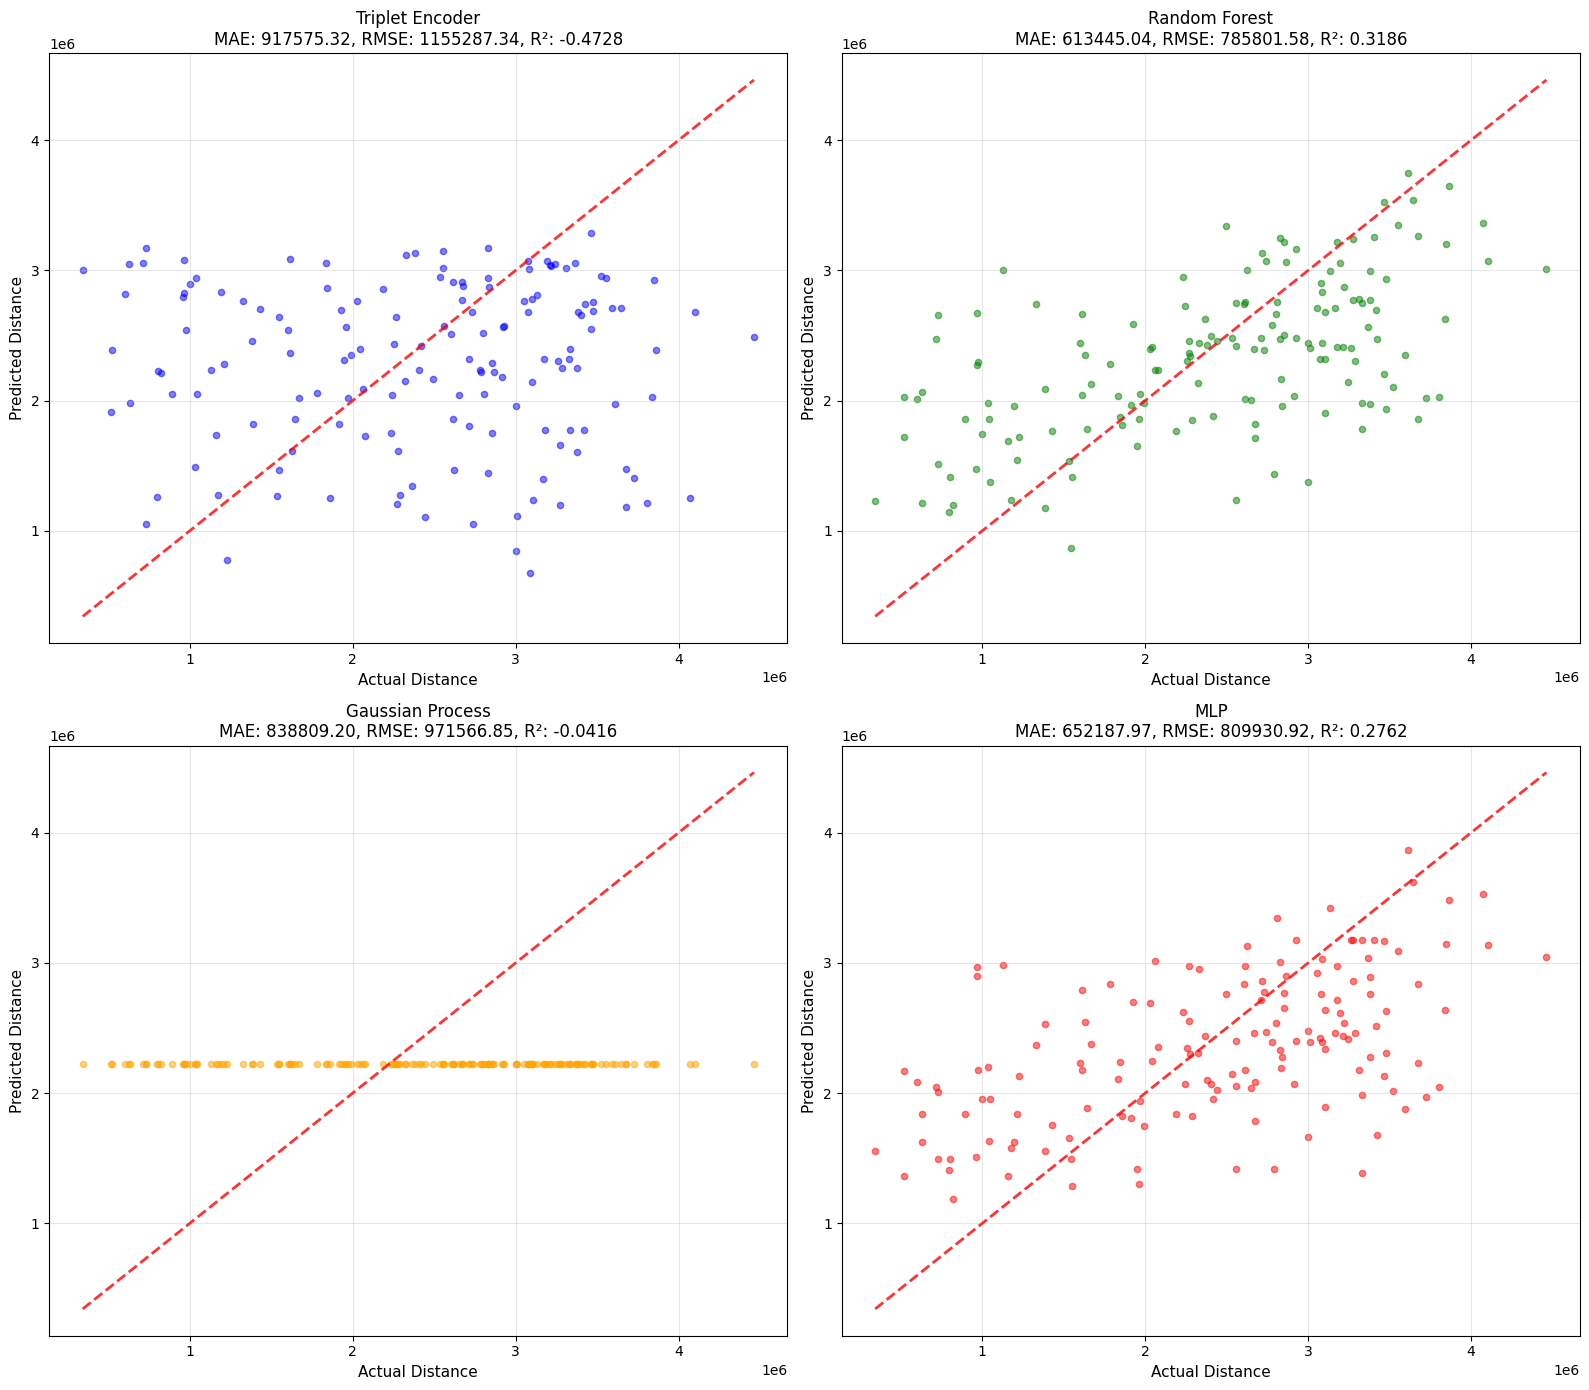

In [ ]:
# Visualize predictions vs actual for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

models = [
    ("Triplet Encoder", y_test_pred_encoder_scaled, "blue"),
    ("Random Forest", y_test_pred_rf, "green"),
    ("Gaussian Process", y_test_pred_gp, "orange"),
    ("MLP", y_test_pred_mlp, "red"),
]

for idx, (name, y_pred, color) in enumerate(models):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    ax.scatter(y_test_distances, y_pred, alpha=0.5, s=20, color=color)

    # Add diagonal line
    min_val = min(y_test_distances.min(), y_pred.min())
    max_val = max(y_test_distances.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8, linewidth=2)

    # Get metrics
    mae = mean_absolute_error(y_test_distances, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_distances, y_pred))
    r2 = 1 - np.sum((y_test_distances - y_pred) ** 2) / np.sum(
        (y_test_distances - np.mean(y_test_distances)) ** 2
    )

    ax.set_xlabel("Actual Distance", fontsize=11)
    ax.set_ylabel("Predicted Distance", fontsize=11)
    ax.set_title(f"{name}\nMAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}", fontsize=12)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

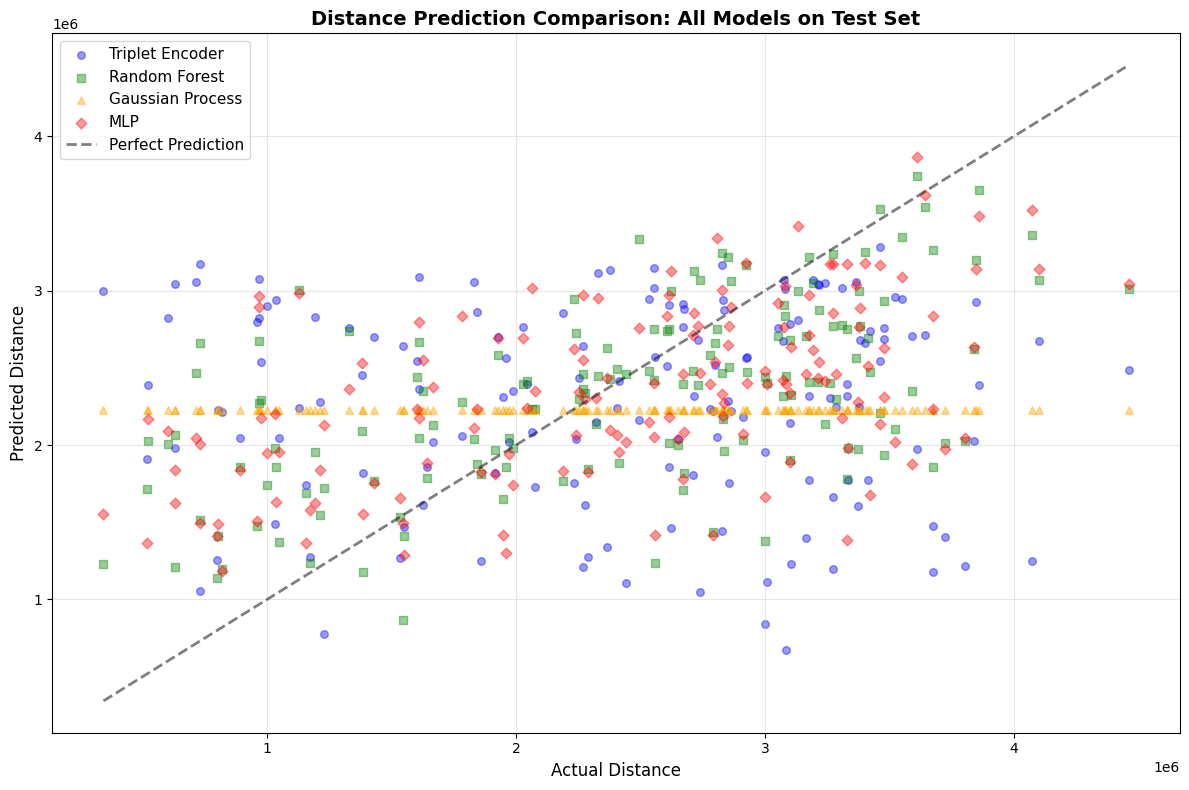

In [ ]:
# Create side-by-side comparison plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

models_plot = [
    ("Triplet Encoder", y_test_pred_encoder_scaled, "blue", "o"),
    ("Random Forest", y_test_pred_rf, "green", "s"),
    ("Gaussian Process", y_test_pred_gp, "orange", "^"),
    ("MLP", y_test_pred_mlp, "red", "D"),
]

for name, y_pred, color, marker in models_plot:
    ax.scatter(
        y_test_distances,
        y_pred,
        alpha=0.4,
        s=30,
        color=color,
        marker=marker,
        label=name,
    )

# Add diagonal line
min_val = min(y_test_distances.min(), min([y.min() for _, y, _, _ in models_plot]))
max_val = max(y_test_distances.max(), max([y.max() for _, y, _, _ in models_plot]))
ax.plot(
    [min_val, max_val],
    [min_val, max_val],
    "k--",
    alpha=0.5,
    linewidth=2,
    label="Perfect Prediction",
)

ax.set_xlabel("Actual Distance", fontsize=12)
ax.set_ylabel("Predicted Distance", fontsize=12)
ax.set_title(
    "Distance Prediction Comparison: All Models on Test Set",
    fontsize=14,
    fontweight="bold",
)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

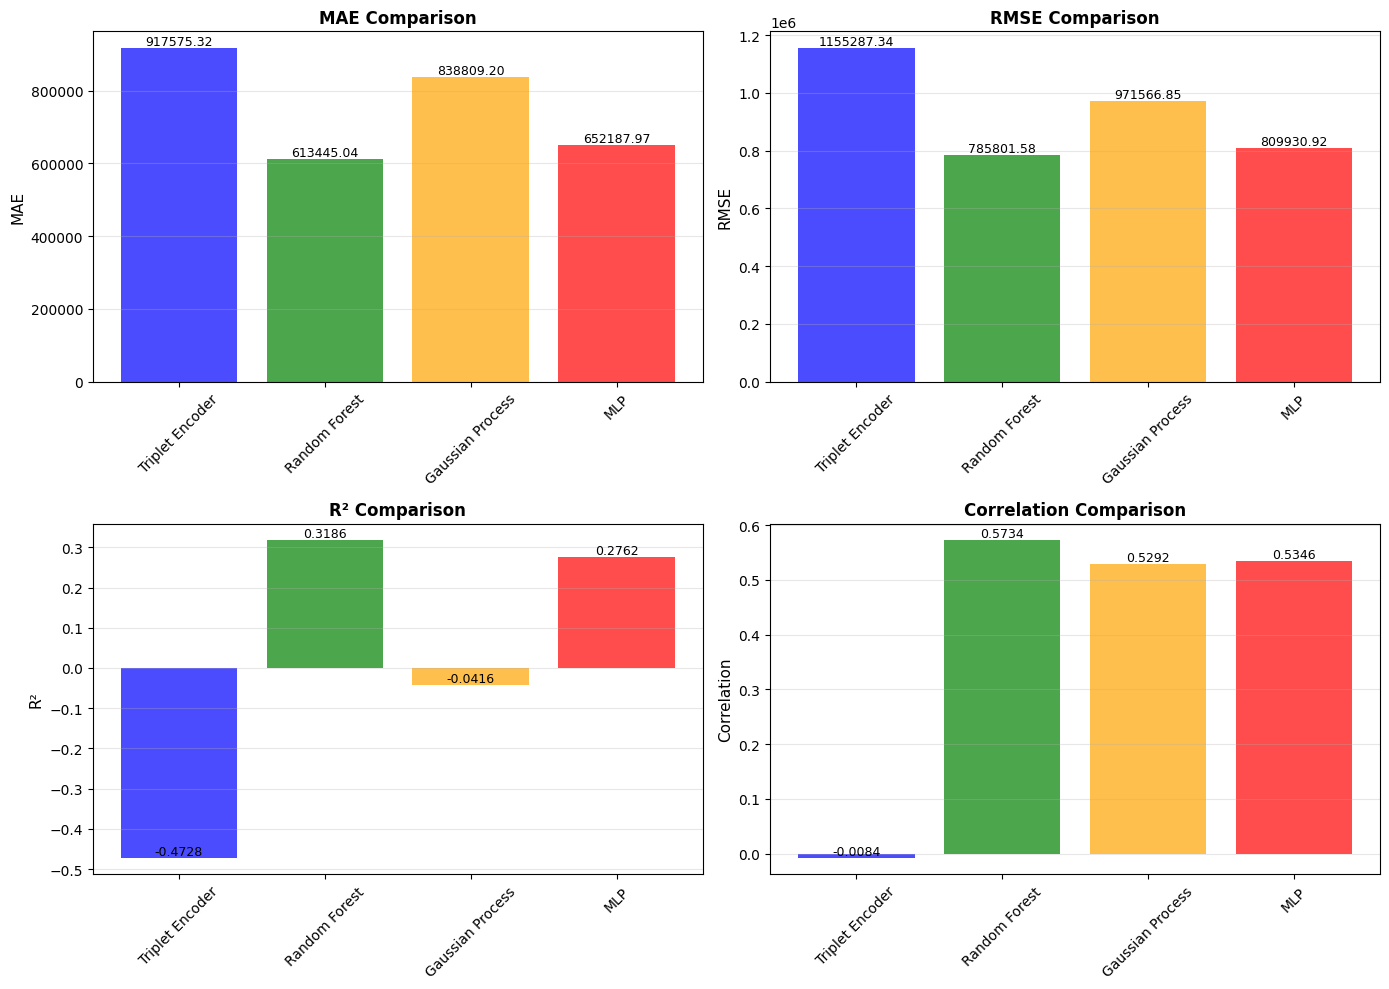

In [ ]:
# Create bar chart comparing metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ["MAE", "RMSE", "R²", "Correlation"]
metric_data = {
    "MAE": [
        results_encoder["mae"],
        results_rf["mae"],
        results_gp["mae"],
        results_mlp["mae"],
    ],
    "RMSE": [
        results_encoder["rmse"],
        results_rf["rmse"],
        results_gp["rmse"],
        results_mlp["rmse"],
    ],
    "R²": [
        results_encoder["r2"],
        results_rf["r2"],
        results_gp["r2"],
        results_mlp["r2"],
    ],
    "Correlation": [
        results_encoder["correlation"],
        results_rf["correlation"],
        results_gp["correlation"],
        results_mlp["correlation"],
    ],
}

model_names = ["Triplet Encoder", "Random Forest", "Gaussian Process", "MLP"]
colors = ["blue", "green", "orange", "red"]

for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    bars = ax.bar(model_names, metric_data[metric], color=colors, alpha=0.7)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f"{metric} Comparison", fontsize=12, fontweight="bold")
    ax.grid(True, alpha=0.3, axis="y")

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.2f}" if metric in ["MAE", "RMSE"] else f"{height:.4f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    # Rotate x-axis labels
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

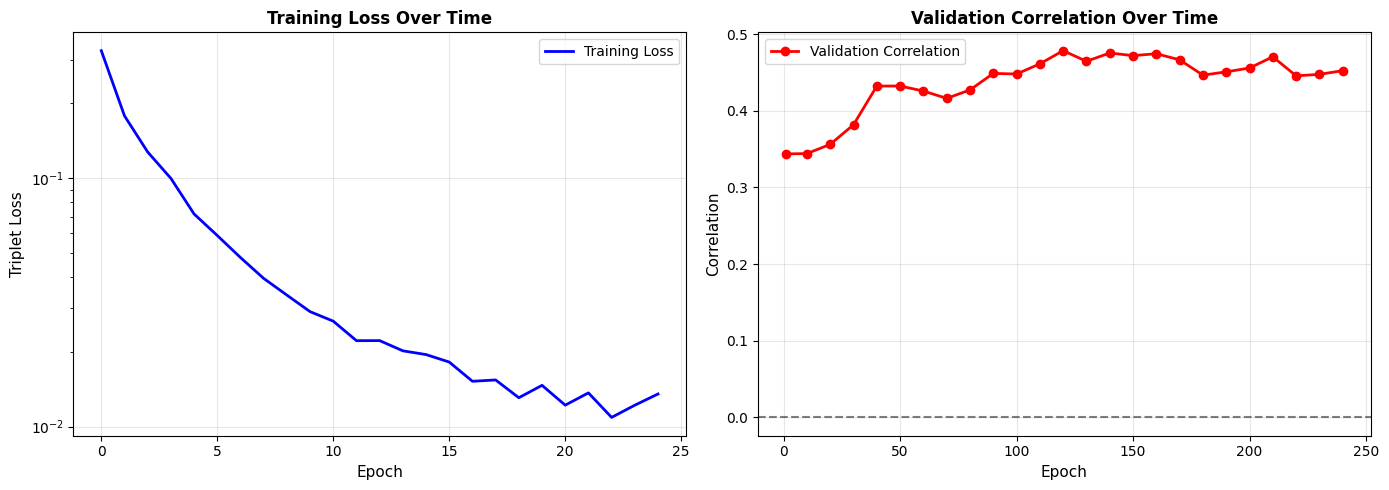


Key Observations:
  Final training loss: 0.013541
  Final validation correlation: 0.4524


In [ ]:
# Plot training and validation metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Training loss
ax1 = axes[0]
ax1.plot(loss_history_eval, "b-", linewidth=2, label="Training Loss")
ax1.set_xlabel("Epoch", fontsize=11)
ax1.set_ylabel("Triplet Loss", fontsize=11)
ax1.set_title("Training Loss Over Time", fontsize=12, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_yscale("log")  # Log scale to see small values

# Right: Validation correlation
ax2 = axes[1]
# Validation correlations are computed at epochs: 1, 10, 20, 30, 40, 50, ...
# (epoch 0+1=1, then every 10 epochs: 10, 20, 30, ...)
# Create epoch numbers matching when correlations were computed
epochs_to_plot = [1] + [10 * i for i in range(1, len(val_correlations))]
# Ensure lengths match (safety check)
epochs_to_plot = epochs_to_plot[: len(val_correlations)]
ax2.plot(
    epochs_to_plot,
    val_correlations,
    "r-o",
    linewidth=2,
    markersize=6,
    label="Validation Correlation",
)
ax2.set_xlabel("Epoch", fontsize=11)
ax2.set_ylabel("Correlation", fontsize=11)
ax2.set_title("Validation Correlation Over Time", fontsize=12, fontweight="bold")
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.axhline(y=0, color="k", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

print(f"\nKey Observations:")
print(f"  Final training loss: {loss_history_eval[-1]:.6f}")
print(f"  Final validation correlation: {val_correlations[-1]:.4f}")
if loss_history_eval[-1] < 0.001:
    print(f"  ⚠️  Warning: Training loss is very low - encoder may be overfitting!")
if abs(val_correlations[-1]) < 0.1:
    print(
        f"  ⚠️  Warning: Validation correlation is near zero - encoder not learning distance relationship!"
    )

### Potential Issues and Solutions

**Why the encoder might perform poorly:**

1. **Triplet loss only optimizes relative ordering** - It ensures A is closer to P than to N, but doesn't optimize for predicting absolute distances
2. **Overfitting to triplets** - Loss → 0 means all triplets are satisfied, but this might be a degenerate solution
3. **L2 normalization** - Forces all vectors to unit length, which might collapse the space
4. **Triplet selection** - Easy triplets don't force the encoder to learn meaningful relationships

**Potential fixes to try:**

1. **Disable normalization** - Set `normalize_output=False` in TripletEncoder
2. **Hard negative mining** - Use harder triplets that are closer to the anchor
3. **Increase margin** - Larger margin forces more separation
4. **More diverse triplets** - Generate more triplets with different difficulty levels
5. **Different architecture** - Try deeper/shallower networks
6. **Regularization** - Add dropout or weight decay to prevent overfitting


### Understanding Correlation vs R²

**Why Gaussian Process has correlation 0.529 but R² = -0.04:**

**Correlation** measures the **linear relationship** between predictions and actual values:

-   Range: -1 to +1
-   Measures: "Do predictions and actuals move together?"
-   **Ignores scale and bias** - only cares about the pattern

**R²** measures how much **variance is explained**:

-   Range: -∞ to +1 (can be negative!)
-   Formula: `R² = 1 - (model_error / baseline_error)`
-   **Accounts for both scale and bias**
-   Negative R² means: **Model performs worse than just predicting the mean**

**Why GP can have positive correlation but negative R²:**

1. **Systematic bias**: Predictions might be consistently too high or too low
2. **Wrong scale**: Predictions might be in the wrong range (e.g., always 2x too large)
3. **Underfitting**: Model hasn't learned the relationship well enough

**Example:**

-   Actual values: [100, 200, 300, 400, 500]
-   Mean: 300
-   Predictions: [250, 350, 450, 550, 650] (always 150 too high)
-   Correlation: 1.0 (perfect linear relationship!)
-   R²: Negative (because predicting mean=300 would be better)

The GP model is learning the **pattern** (correlation = 0.53) but making predictions that are systematically wrong in scale/bias, making them worse than the mean predictor.


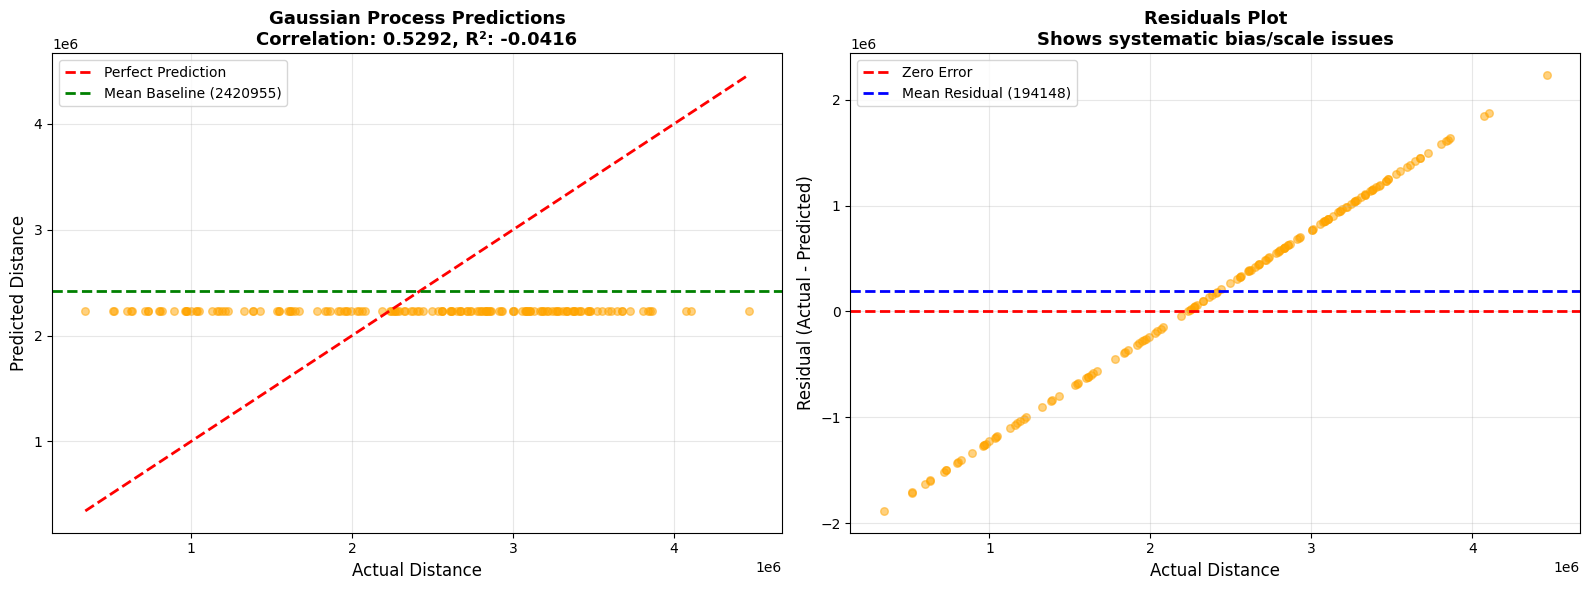

Gaussian Process Diagnostics:
Mean of actual values:     2420955.12
Mean of predictions:        2226806.85
Mean residual (bias):       194148.27
Std of residuals:           951970.90

Baseline error (using mean): 1.39e+14
Model error:                 1.44e+14

Model error > Baseline error: True
This is why R² is negative!


In [ ]:
# Visualize why GP has positive correlation but negative R²
# Let's look at the GP predictions vs actual

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Scatter plot with actual vs predicted
ax1 = axes[0]
ax1.scatter(y_test_distances, y_test_pred_gp, alpha=0.5, s=30, color="orange")
min_val = min(y_test_distances.min(), y_test_pred_gp.min())
max_val = max(y_test_distances.max(), y_test_pred_gp.max())
ax1.plot(
    [min_val, max_val],
    [min_val, max_val],
    "r--",
    linewidth=2,
    label="Perfect Prediction",
)
ax1.axhline(
    y=np.mean(y_test_distances),
    color="g",
    linestyle="--",
    linewidth=2,
    label=f"Mean Baseline ({np.mean(y_test_distances):.0f})",
)
ax1.set_xlabel("Actual Distance", fontsize=12)
ax1.set_ylabel("Predicted Distance", fontsize=12)
ax1.set_title(
    f'Gaussian Process Predictions\nCorrelation: {results_gp["correlation"]:.4f}, R²: {results_gp["r2"]:.4f}',
    fontsize=13,
    fontweight="bold",
)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Residuals plot (errors vs actual)
ax2 = axes[1]
residuals = y_test_distances - y_test_pred_gp
ax2.scatter(y_test_distances, residuals, alpha=0.5, s=30, color="orange")
ax2.axhline(y=0, color="r", linestyle="--", linewidth=2, label="Zero Error")
ax2.axhline(
    y=np.mean(residuals),
    color="b",
    linestyle="--",
    linewidth=2,
    label=f"Mean Residual ({np.mean(residuals):.0f})",
)
ax2.set_xlabel("Actual Distance", fontsize=12)
ax2.set_ylabel("Residual (Actual - Predicted)", fontsize=12)
ax2.set_title(
    "Residuals Plot\nShows systematic bias/scale issues", fontsize=13, fontweight="bold"
)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print diagnostics
print("=" * 60)
print("Gaussian Process Diagnostics:")
print("=" * 60)
print(f"Mean of actual values:     {np.mean(y_test_distances):.2f}")
print(f"Mean of predictions:        {np.mean(y_test_pred_gp):.2f}")
print(f"Mean residual (bias):       {np.mean(residuals):.2f}")
print(f"Std of residuals:           {np.std(residuals):.2f}")
print(
    f"\nBaseline error (using mean): {np.sum((y_test_distances - np.mean(y_test_distances))**2):.2e}"
)
print(f"Model error:                 {np.sum(residuals**2):.2e}")
print(
    f"\nModel error > Baseline error: {np.sum(residuals**2) > np.sum((y_test_distances - np.mean(y_test_distances))**2)}"
)
print(f"This is why R² is negative!")

In [ ]:
# Example usage of run_active_coverage_cycles_with_encoder
# This demonstrates how to use the encoder-based novelty search

# Get initial cases from valid results
initial_cases_enc = [
    r.test_case for r in valid_results[:50]
]  # Use subset for faster demo

print("Running encoder-based active coverage cycles...")
print("Note: This will train an encoder and run multiple cycles of novelty search")
print(
    "This may take several minutes depending on the number of cycles and candidates\n"
)

# Uncomment to run (commented out to avoid long execution during development):
results_enc, trajectories_enc, features_enc = run_active_coverage_cycles_with_encoder(
    init_cases=initial_cases_enc,
    cycles=2,  # Fewer cycles for demo
    per_cycle_new=10,
    n_candidates=10000,  # Fewer candidates for faster demo
    latent_dim=8,
    encoder_epochs=30,  # Fewer epochs for faster demo
    seed=seed,
    cache_distances=True,
)

# Print summary if run
print(f"\nFinal Results:")
print(f"  Total results: {len(results_enc)}")
print(f"  Valid trajectories: {len(trajectories_enc)}")
print(f"  Features shape: {features_enc.shape}")

print("Example usage code is ready. Uncomment the function call above to execute.")

Running encoder-based active coverage cycles...
Note: This will train an encoder and run multiple cycles of novelty search
This may take several minutes depending on the number of cycles and candidates

Encoder-Based Active Coverage Cycles
Initial cases: 50
Valid results: 50
Features shape: (50, 8)
Loading distance matrix from cache/distance_matrix_seed100_size50.npy
Distance matrix shape: (50, 50)

Training Triplet Encoder...
Generated 10000 valid triplets
Positive threshold (percentile 20): 1231702.24
Negative threshold (percentile 80): 2913459.23
Training Triplet Encoder...
  Input dimension: 8
  Latent dimension: 8
  Number of triplets: 10000
  Batch size: 64
  Epochs: 30
  Margin: 0.5
  Dropout rate: 0.4
  Weight decay: 0.0001

Epoch 1/30 - Average Loss: 0.281239
Epoch 10/30 - Average Loss: 0.012586
Epoch 20/30 - Average Loss: 0.005287
Epoch 30/30 - Average Loss: 0.003785

Training completed!
Final loss: 0.003785

Encoded 50 initial conditions to latent space
Latent vectors shape: